## Import

In [4]:
!sudo pip uninstall opencv-python --y

Found existing installation: opencv-python 4.9.0.80
Uninstalling opencv-python-4.9.0.80:
  Successfully uninstalled opencv-python-4.9.0.80


In [2]:
!pip install --upgrade opencv-python


Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 286.0 MB/s eta 0:00:0000:0100:01
DEPRECATION: devscripts 2.22.1ubuntu1 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of devscripts or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.2 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip


In [1]:
import io
import zipfile
from zipfile import ZipFile
import requests

import random
import pandas as pd
import numpy as np
import os
import re
import glob
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torchvision.models as models

from tqdm import tqdm

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Hyperparameter Setting

In [3]:
CFG = {
    'IMG_SIZE': 299,  # Inception 모델 입력 크기
    'EPOCHS': 10 , # 10 이상
    'LEARNING_RATE': 3e-4,
    'BATCH_SIZE': 32,
    'SEED': 41
}


## Fixed RandomSeed

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

## Data Pre-processing

In [7]:
file_name = "./open/open.zip"
output_dir = "./open2"
os.system("unzip "+file_name+" -d "+output_dir)

Archive:  ./open/open.zip
  inflating: ./open2/sample_submission.csv  
  inflating: ./open2/test.csv        
   creating: ./open2/test/
  inflating: ./open2/test/TEST_0000.png  
  inflating: ./open2/test/TEST_0001.png  
  inflating: ./open2/test/TEST_0002.png  
  inflating: ./open2/test/TEST_0003.png  
  inflating: ./open2/test/TEST_0004.png  
  inflating: ./open2/test/TEST_0005.png  
  inflating: ./open2/test/TEST_0006.png  
  inflating: ./open2/test/TEST_0007.png  
  inflating: ./open2/test/TEST_0008.png  
  inflating: ./open2/test/TEST_0009.png  
  inflating: ./open2/test/TEST_0010.png  
  inflating: ./open2/test/TEST_0011.png  
  inflating: ./open2/test/TEST_0012.png  
  inflating: ./open2/test/TEST_0013.png  
  inflating: ./open2/test/TEST_0014.png  
  inflating: ./open2/test/TEST_0015.png  
  inflating: ./open2/test/TEST_0016.png  
  inflating: ./open2/test/TEST_0017.png  
  inflating: ./open2/test/TEST_0018.png  
  inflating: ./open2/test/TEST_0019.png  
  inflating: ./open2/tes

  inflating: ./open2/test/TEST_0237.png  
  inflating: ./open2/test/TEST_0238.png  
  inflating: ./open2/test/TEST_0239.png  
  inflating: ./open2/test/TEST_0240.png  
  inflating: ./open2/test/TEST_0241.png  
  inflating: ./open2/test/TEST_0242.png  
  inflating: ./open2/test/TEST_0243.png  
  inflating: ./open2/test/TEST_0244.png  
  inflating: ./open2/test/TEST_0245.png  
  inflating: ./open2/test/TEST_0246.png  
  inflating: ./open2/test/TEST_0247.png  
  inflating: ./open2/test/TEST_0248.png  
  inflating: ./open2/test/TEST_0249.png  
  inflating: ./open2/test/TEST_0250.png  
  inflating: ./open2/test/TEST_0251.png  
  inflating: ./open2/test/TEST_0252.png  
  inflating: ./open2/test/TEST_0253.png  
  inflating: ./open2/test/TEST_0254.png  
  inflating: ./open2/test/TEST_0255.png  
  inflating: ./open2/test/TEST_0256.png  
  inflating: ./open2/test/TEST_0257.png  
  inflating: ./open2/test/TEST_0258.png  
  inflating: ./open2/test/TEST_0259.png  
  inflating: ./open2/test/TEST_026

  inflating: ./open2/test/TEST_0461.png  
  inflating: ./open2/test/TEST_0462.png  
  inflating: ./open2/test/TEST_0463.png  
  inflating: ./open2/test/TEST_0464.png  
  inflating: ./open2/test/TEST_0465.png  
  inflating: ./open2/test/TEST_0466.png  
  inflating: ./open2/test/TEST_0467.png  
  inflating: ./open2/test/TEST_0468.png  
  inflating: ./open2/test/TEST_0469.png  
  inflating: ./open2/test/TEST_0470.png  
  inflating: ./open2/test/TEST_0471.png  
  inflating: ./open2/test/TEST_0472.png  
  inflating: ./open2/test/TEST_0473.png  
  inflating: ./open2/test/TEST_0474.png  
  inflating: ./open2/test/TEST_0475.png  
  inflating: ./open2/test/TEST_0476.png  
  inflating: ./open2/test/TEST_0477.png  
  inflating: ./open2/test/TEST_0478.png  
  inflating: ./open2/test/TEST_0479.png  
  inflating: ./open2/test/TEST_0480.png  
  inflating: ./open2/test/TEST_0481.png  
  inflating: ./open2/test/TEST_0482.png  
  inflating: ./open2/test/TEST_0483.png  
  inflating: ./open2/test/TEST_048

  inflating: ./open2/test/TEST_0701.png  
  inflating: ./open2/test/TEST_0702.png  
  inflating: ./open2/test/TEST_0703.png  
  inflating: ./open2/test/TEST_0704.png  
  inflating: ./open2/test/TEST_0705.png  
  inflating: ./open2/test/TEST_0706.png  
  inflating: ./open2/test/TEST_0707.png  
  inflating: ./open2/test/TEST_0708.png  
  inflating: ./open2/test/TEST_0709.png  
  inflating: ./open2/test/TEST_0710.png  
  inflating: ./open2/test/TEST_0711.png  
  inflating: ./open2/test/TEST_0712.png  
  inflating: ./open2/test/TEST_0713.png  
  inflating: ./open2/test/TEST_0714.png  
  inflating: ./open2/test/TEST_0715.png  
  inflating: ./open2/test/TEST_0716.png  
  inflating: ./open2/test/TEST_0717.png  
  inflating: ./open2/test/TEST_0718.png  
  inflating: ./open2/test/TEST_0719.png  
  inflating: ./open2/test/TEST_0720.png  
  inflating: ./open2/test/TEST_0721.png  
  inflating: ./open2/test/TEST_0722.png  
  inflating: ./open2/test/TEST_0723.png  
  inflating: ./open2/test/TEST_072

  inflating: ./open2/test/TEST_0945.png  
  inflating: ./open2/test/TEST_0946.png  
  inflating: ./open2/test/TEST_0947.png  
  inflating: ./open2/test/TEST_0948.png  
  inflating: ./open2/test/TEST_0949.png  
  inflating: ./open2/test/TEST_0950.png  
  inflating: ./open2/test/TEST_0951.png  
  inflating: ./open2/test/TEST_0952.png  
  inflating: ./open2/test/TEST_0953.png  
  inflating: ./open2/test/TEST_0954.png  
  inflating: ./open2/test/TEST_0955.png  
  inflating: ./open2/test/TEST_0956.png  
  inflating: ./open2/test/TEST_0957.png  
  inflating: ./open2/test/TEST_0958.png  
  inflating: ./open2/test/TEST_0959.png  
  inflating: ./open2/test/TEST_0960.png  
  inflating: ./open2/test/TEST_0961.png  
  inflating: ./open2/test/TEST_0962.png  
  inflating: ./open2/test/TEST_0963.png  
  inflating: ./open2/test/TEST_0964.png  
  inflating: ./open2/test/TEST_0965.png  
  inflating: ./open2/test/TEST_0966.png  
  inflating: ./open2/test/TEST_0967.png  
  inflating: ./open2/test/TEST_096

  inflating: ./open2/test/TEST_1189.png  
  inflating: ./open2/test/TEST_1190.png  
  inflating: ./open2/test/TEST_1191.png  
  inflating: ./open2/test/TEST_1192.png  
  inflating: ./open2/test/TEST_1193.png  
  inflating: ./open2/test/TEST_1194.png  
  inflating: ./open2/test/TEST_1195.png  
  inflating: ./open2/test/TEST_1196.png  
  inflating: ./open2/test/TEST_1197.png  
  inflating: ./open2/test/TEST_1198.png  
  inflating: ./open2/test/TEST_1199.png  
  inflating: ./open2/test/TEST_1200.png  
  inflating: ./open2/test/TEST_1201.png  
  inflating: ./open2/test/TEST_1202.png  
  inflating: ./open2/test/TEST_1203.png  
  inflating: ./open2/test/TEST_1204.png  
  inflating: ./open2/test/TEST_1205.png  
  inflating: ./open2/test/TEST_1206.png  
  inflating: ./open2/test/TEST_1207.png  
  inflating: ./open2/test/TEST_1208.png  
  inflating: ./open2/test/TEST_1209.png  
  inflating: ./open2/test/TEST_1210.png  
  inflating: ./open2/test/TEST_1211.png  
  inflating: ./open2/test/TEST_121

  inflating: ./open2/test/TEST_1386.png  
  inflating: ./open2/test/TEST_1387.png  
  inflating: ./open2/test/TEST_1388.png  
  inflating: ./open2/test/TEST_1389.png  
  inflating: ./open2/test/TEST_1390.png  
  inflating: ./open2/test/TEST_1391.png  
  inflating: ./open2/test/TEST_1392.png  
  inflating: ./open2/test/TEST_1393.png  
  inflating: ./open2/test/TEST_1394.png  
  inflating: ./open2/test/TEST_1395.png  
  inflating: ./open2/test/TEST_1396.png  
  inflating: ./open2/test/TEST_1397.png  
  inflating: ./open2/test/TEST_1398.png  
  inflating: ./open2/test/TEST_1399.png  
  inflating: ./open2/test/TEST_1400.png  
  inflating: ./open2/test/TEST_1401.png  
  inflating: ./open2/test/TEST_1402.png  
  inflating: ./open2/test/TEST_1403.png  
  inflating: ./open2/test/TEST_1404.png  
  inflating: ./open2/test/TEST_1405.png  
  inflating: ./open2/test/TEST_1406.png  
  inflating: ./open2/test/TEST_1407.png  
  inflating: ./open2/test/TEST_1408.png  
  inflating: ./open2/test/TEST_140

  inflating: ./open2/test/TEST_1627.png  
  inflating: ./open2/test/TEST_1628.png  
  inflating: ./open2/test/TEST_1629.png  
  inflating: ./open2/test/TEST_1630.png  
  inflating: ./open2/test/TEST_1631.png  
  inflating: ./open2/test/TEST_1632.png  
  inflating: ./open2/test/TEST_1633.png  
  inflating: ./open2/test/TEST_1634.png  
  inflating: ./open2/test/TEST_1635.png  
  inflating: ./open2/test/TEST_1636.png  
  inflating: ./open2/test/TEST_1637.png  
  inflating: ./open2/test/TEST_1638.png  
  inflating: ./open2/test/TEST_1639.png  
  inflating: ./open2/test/TEST_1640.png  
  inflating: ./open2/test/TEST_1641.png  
  inflating: ./open2/test/TEST_1642.png  
  inflating: ./open2/test/TEST_1643.png  
  inflating: ./open2/test/TEST_1644.png  
  inflating: ./open2/test/TEST_1645.png  
  inflating: ./open2/test/TEST_1646.png  
  inflating: ./open2/test/TEST_1647.png  
  inflating: ./open2/test/TEST_1648.png  
  inflating: ./open2/test/TEST_1649.png  
  inflating: ./open2/test/TEST_165

  inflating: ./open2/test/TEST_1856.png  
  inflating: ./open2/test/TEST_1857.png  
  inflating: ./open2/test/TEST_1858.png  
  inflating: ./open2/test/TEST_1859.png  
  inflating: ./open2/test/TEST_1860.png  
  inflating: ./open2/test/TEST_1861.png  
  inflating: ./open2/test/TEST_1862.png  
  inflating: ./open2/test/TEST_1863.png  
  inflating: ./open2/test/TEST_1864.png  
  inflating: ./open2/test/TEST_1865.png  
  inflating: ./open2/test/TEST_1866.png  
  inflating: ./open2/test/TEST_1867.png  
  inflating: ./open2/test/TEST_1868.png  
  inflating: ./open2/test/TEST_1869.png  
  inflating: ./open2/test/TEST_1870.png  
  inflating: ./open2/test/TEST_1871.png  
  inflating: ./open2/test/TEST_1872.png  
  inflating: ./open2/test/TEST_1873.png  
  inflating: ./open2/test/TEST_1874.png  
  inflating: ./open2/test/TEST_1875.png  
  inflating: ./open2/test/TEST_1876.png  
  inflating: ./open2/test/TEST_1877.png  
  inflating: ./open2/test/TEST_1878.png  
  inflating: ./open2/test/TEST_187

  inflating: ./open2/test/TEST_2098.png  
  inflating: ./open2/test/TEST_2099.png  
  inflating: ./open2/test/TEST_2100.png  
  inflating: ./open2/test/TEST_2101.png  
  inflating: ./open2/test/TEST_2102.png  
  inflating: ./open2/test/TEST_2103.png  
  inflating: ./open2/test/TEST_2104.png  
  inflating: ./open2/test/TEST_2105.png  
  inflating: ./open2/test/TEST_2106.png  
  inflating: ./open2/test/TEST_2107.png  
  inflating: ./open2/test/TEST_2108.png  
  inflating: ./open2/test/TEST_2109.png  
  inflating: ./open2/test/TEST_2110.png  
  inflating: ./open2/test/TEST_2111.png  
  inflating: ./open2/test/TEST_2112.png  
  inflating: ./open2/test/TEST_2113.png  
  inflating: ./open2/test/TEST_2114.png  
  inflating: ./open2/test/TEST_2115.png  
  inflating: ./open2/test/TEST_2116.png  
  inflating: ./open2/test/TEST_2117.png  
  inflating: ./open2/test/TEST_2118.png  
  inflating: ./open2/test/TEST_2119.png  
  inflating: ./open2/test/TEST_2120.png  
  inflating: ./open2/test/TEST_212

  inflating: ./open2/train/TRAIN_0062.png  
  inflating: ./open2/train/TRAIN_0063.png  
  inflating: ./open2/train/TRAIN_0064.png  
  inflating: ./open2/train/TRAIN_0065.png  
  inflating: ./open2/train/TRAIN_0066.png  
  inflating: ./open2/train/TRAIN_0067.png  
  inflating: ./open2/train/TRAIN_0068.png  
  inflating: ./open2/train/TRAIN_0069.png  
  inflating: ./open2/train/TRAIN_0070.png  
  inflating: ./open2/train/TRAIN_0071.png  
  inflating: ./open2/train/TRAIN_0072.png  
  inflating: ./open2/train/TRAIN_0073.png  
  inflating: ./open2/train/TRAIN_0074.png  
  inflating: ./open2/train/TRAIN_0075.png  
  inflating: ./open2/train/TRAIN_0076.png  
  inflating: ./open2/train/TRAIN_0077.png  
  inflating: ./open2/train/TRAIN_0078.png  
  inflating: ./open2/train/TRAIN_0079.png  
  inflating: ./open2/train/TRAIN_0080.png  
  inflating: ./open2/train/TRAIN_0081.png  
  inflating: ./open2/train/TRAIN_0082.png  
  inflating: ./open2/train/TRAIN_0083.png  
  inflating: ./open2/train/TRAIN

  inflating: ./open2/train/TRAIN_0293.png  
  inflating: ./open2/train/TRAIN_0294.png  
  inflating: ./open2/train/TRAIN_0295.png  
  inflating: ./open2/train/TRAIN_0296.png  
  inflating: ./open2/train/TRAIN_0297.png  
  inflating: ./open2/train/TRAIN_0298.png  
  inflating: ./open2/train/TRAIN_0299.png  
  inflating: ./open2/train/TRAIN_0300.png  
  inflating: ./open2/train/TRAIN_0301.png  
  inflating: ./open2/train/TRAIN_0302.png  
  inflating: ./open2/train/TRAIN_0303.png  
  inflating: ./open2/train/TRAIN_0304.png  
  inflating: ./open2/train/TRAIN_0305.png  
  inflating: ./open2/train/TRAIN_0306.png  
  inflating: ./open2/train/TRAIN_0307.png  
  inflating: ./open2/train/TRAIN_0308.png  
  inflating: ./open2/train/TRAIN_0309.png  
  inflating: ./open2/train/TRAIN_0310.png  
  inflating: ./open2/train/TRAIN_0311.png  
  inflating: ./open2/train/TRAIN_0312.png  
  inflating: ./open2/train/TRAIN_0313.png  
  inflating: ./open2/train/TRAIN_0314.png  
  inflating: ./open2/train/TRAIN

  inflating: ./open2/train/TRAIN_0529.png  
  inflating: ./open2/train/TRAIN_0530.png  
  inflating: ./open2/train/TRAIN_0531.png  
  inflating: ./open2/train/TRAIN_0532.png  
  inflating: ./open2/train/TRAIN_0533.png  
  inflating: ./open2/train/TRAIN_0534.png  
  inflating: ./open2/train/TRAIN_0535.png  
  inflating: ./open2/train/TRAIN_0536.png  
  inflating: ./open2/train/TRAIN_0537.png  
  inflating: ./open2/train/TRAIN_0538.png  
  inflating: ./open2/train/TRAIN_0539.png  
  inflating: ./open2/train/TRAIN_0540.png  
  inflating: ./open2/train/TRAIN_0541.png  
  inflating: ./open2/train/TRAIN_0542.png  
  inflating: ./open2/train/TRAIN_0543.png  
  inflating: ./open2/train/TRAIN_0544.png  
  inflating: ./open2/train/TRAIN_0545.png  
  inflating: ./open2/train/TRAIN_0546.png  
  inflating: ./open2/train/TRAIN_0547.png  
  inflating: ./open2/train/TRAIN_0548.png  
  inflating: ./open2/train/TRAIN_0549.png  
  inflating: ./open2/train/TRAIN_0550.png  
  inflating: ./open2/train/TRAIN

  inflating: ./open2/train/TRAIN_0718.png  
  inflating: ./open2/train/TRAIN_0719.png  
  inflating: ./open2/train/TRAIN_0720.png  
  inflating: ./open2/train/TRAIN_0721.png  
  inflating: ./open2/train/TRAIN_0722.png  
  inflating: ./open2/train/TRAIN_0723.png  
  inflating: ./open2/train/TRAIN_0724.png  
  inflating: ./open2/train/TRAIN_0725.png  
  inflating: ./open2/train/TRAIN_0726.png  
  inflating: ./open2/train/TRAIN_0727.png  
  inflating: ./open2/train/TRAIN_0728.png  
  inflating: ./open2/train/TRAIN_0729.png  
  inflating: ./open2/train/TRAIN_0730.png  
  inflating: ./open2/train/TRAIN_0731.png  
  inflating: ./open2/train/TRAIN_0732.png  
  inflating: ./open2/train/TRAIN_0733.png  
  inflating: ./open2/train/TRAIN_0734.png  
  inflating: ./open2/train/TRAIN_0735.png  
  inflating: ./open2/train/TRAIN_0736.png  
  inflating: ./open2/train/TRAIN_0737.png  
  inflating: ./open2/train/TRAIN_0738.png  
  inflating: ./open2/train/TRAIN_0739.png  
  inflating: ./open2/train/TRAIN

  inflating: ./open2/train/TRAIN_0908.png  
  inflating: ./open2/train/TRAIN_0909.png  
  inflating: ./open2/train/TRAIN_0910.png  
  inflating: ./open2/train/TRAIN_0911.png  
  inflating: ./open2/train/TRAIN_0912.png  
  inflating: ./open2/train/TRAIN_0913.png  
  inflating: ./open2/train/TRAIN_0914.png  
  inflating: ./open2/train/TRAIN_0915.png  
  inflating: ./open2/train/TRAIN_0916.png  
  inflating: ./open2/train/TRAIN_0917.png  
  inflating: ./open2/train/TRAIN_0918.png  
  inflating: ./open2/train/TRAIN_0919.png  
  inflating: ./open2/train/TRAIN_0920.png  
  inflating: ./open2/train/TRAIN_0921.png  
  inflating: ./open2/train/TRAIN_0922.png  
  inflating: ./open2/train/TRAIN_0923.png  
  inflating: ./open2/train/TRAIN_0924.png  
  inflating: ./open2/train/TRAIN_0925.png  
  inflating: ./open2/train/TRAIN_0926.png  
  inflating: ./open2/train/TRAIN_0927.png  
  inflating: ./open2/train/TRAIN_0928.png  
  inflating: ./open2/train/TRAIN_0929.png  
  inflating: ./open2/train/TRAIN

  inflating: ./open2/train/TRAIN_1101.png  
  inflating: ./open2/train/TRAIN_1102.png  
  inflating: ./open2/train/TRAIN_1103.png  
  inflating: ./open2/train/TRAIN_1104.png  
  inflating: ./open2/train/TRAIN_1105.png  
  inflating: ./open2/train/TRAIN_1106.png  
  inflating: ./open2/train/TRAIN_1107.png  
  inflating: ./open2/train/TRAIN_1108.png  
  inflating: ./open2/train/TRAIN_1109.png  
  inflating: ./open2/train/TRAIN_1110.png  
  inflating: ./open2/train/TRAIN_1111.png  
  inflating: ./open2/train/TRAIN_1112.png  
  inflating: ./open2/train/TRAIN_1113.png  
  inflating: ./open2/train/TRAIN_1114.png  
  inflating: ./open2/train/TRAIN_1115.png  
  inflating: ./open2/train/TRAIN_1116.png  
  inflating: ./open2/train/TRAIN_1117.png  
  inflating: ./open2/train/TRAIN_1118.png  
  inflating: ./open2/train/TRAIN_1119.png  
  inflating: ./open2/train/TRAIN_1120.png  
  inflating: ./open2/train/TRAIN_1121.png  
  inflating: ./open2/train/TRAIN_1122.png  
  inflating: ./open2/train/TRAIN

  inflating: ./open2/train/TRAIN_1297.png  
  inflating: ./open2/train/TRAIN_1298.png  
  inflating: ./open2/train/TRAIN_1299.png  
  inflating: ./open2/train/TRAIN_1300.png  
  inflating: ./open2/train/TRAIN_1301.png  
  inflating: ./open2/train/TRAIN_1302.png  
  inflating: ./open2/train/TRAIN_1303.png  
  inflating: ./open2/train/TRAIN_1304.png  
  inflating: ./open2/train/TRAIN_1305.png  
  inflating: ./open2/train/TRAIN_1306.png  
  inflating: ./open2/train/TRAIN_1307.png  
  inflating: ./open2/train/TRAIN_1308.png  
  inflating: ./open2/train/TRAIN_1309.png  
  inflating: ./open2/train/TRAIN_1310.png  
  inflating: ./open2/train/TRAIN_1311.png  
  inflating: ./open2/train/TRAIN_1312.png  
  inflating: ./open2/train/TRAIN_1313.png  
  inflating: ./open2/train/TRAIN_1314.png  
  inflating: ./open2/train/TRAIN_1315.png  
  inflating: ./open2/train/TRAIN_1316.png  
  inflating: ./open2/train/TRAIN_1317.png  
  inflating: ./open2/train/TRAIN_1318.png  
  inflating: ./open2/train/TRAIN

  inflating: ./open2/train/TRAIN_1487.png  
  inflating: ./open2/train/TRAIN_1488.png  
  inflating: ./open2/train/TRAIN_1489.png  
  inflating: ./open2/train/TRAIN_1490.png  
  inflating: ./open2/train/TRAIN_1491.png  
  inflating: ./open2/train/TRAIN_1492.png  
  inflating: ./open2/train/TRAIN_1493.png  
  inflating: ./open2/train/TRAIN_1494.png  
  inflating: ./open2/train/TRAIN_1495.png  
  inflating: ./open2/train/TRAIN_1496.png  
  inflating: ./open2/train/TRAIN_1497.png  
  inflating: ./open2/train/TRAIN_1498.png  
  inflating: ./open2/train/TRAIN_1499.png  
  inflating: ./open2/train/TRAIN_1500.png  
  inflating: ./open2/train/TRAIN_1501.png  
  inflating: ./open2/train/TRAIN_1502.png  
  inflating: ./open2/train/TRAIN_1503.png  
  inflating: ./open2/train/TRAIN_1504.png  
  inflating: ./open2/train/TRAIN_1505.png  
  inflating: ./open2/train/TRAIN_1506.png  
  inflating: ./open2/train/TRAIN_1507.png  
  inflating: ./open2/train/TRAIN_1508.png  
  inflating: ./open2/train/TRAIN

  inflating: ./open2/train/TRAIN_1687.png  
  inflating: ./open2/train/TRAIN_1688.png  
  inflating: ./open2/train/TRAIN_1689.png  
  inflating: ./open2/train/TRAIN_1690.png  
  inflating: ./open2/train/TRAIN_1691.png  
  inflating: ./open2/train/TRAIN_1692.png  
  inflating: ./open2/train/TRAIN_1693.png  
  inflating: ./open2/train/TRAIN_1694.png  
  inflating: ./open2/train/TRAIN_1695.png  
  inflating: ./open2/train/TRAIN_1696.png  
  inflating: ./open2/train/TRAIN_1697.png  
  inflating: ./open2/train/TRAIN_1698.png  
  inflating: ./open2/train/TRAIN_1699.png  
  inflating: ./open2/train/TRAIN_1700.png  
  inflating: ./open2/train/TRAIN_1701.png  
  inflating: ./open2/train/TRAIN_1702.png  
  inflating: ./open2/train/TRAIN_1703.png  
  inflating: ./open2/train/TRAIN_1704.png  
  inflating: ./open2/train/TRAIN_1705.png  
  inflating: ./open2/train/TRAIN_1706.png  
  inflating: ./open2/train/TRAIN_1707.png  
  inflating: ./open2/train/TRAIN_1708.png  
  inflating: ./open2/train/TRAIN

  inflating: ./open2/train/TRAIN_1878.png  
  inflating: ./open2/train/TRAIN_1879.png  
  inflating: ./open2/train/TRAIN_1880.png  
  inflating: ./open2/train/TRAIN_1881.png  
  inflating: ./open2/train/TRAIN_1882.png  
  inflating: ./open2/train/TRAIN_1883.png  
  inflating: ./open2/train/TRAIN_1884.png  
  inflating: ./open2/train/TRAIN_1885.png  
  inflating: ./open2/train/TRAIN_1886.png  
  inflating: ./open2/train/TRAIN_1887.png  
  inflating: ./open2/train/TRAIN_1888.png  
  inflating: ./open2/train/TRAIN_1889.png  
  inflating: ./open2/train/TRAIN_1890.png  
  inflating: ./open2/train/TRAIN_1891.png  
  inflating: ./open2/train/TRAIN_1892.png  
  inflating: ./open2/train/TRAIN_1893.png  
  inflating: ./open2/train/TRAIN_1894.png  
  inflating: ./open2/train/TRAIN_1895.png  
  inflating: ./open2/train/TRAIN_1896.png  
  inflating: ./open2/train/TRAIN_1897.png  
  inflating: ./open2/train/TRAIN_1898.png  
  inflating: ./open2/train/TRAIN_1899.png  
  inflating: ./open2/train/TRAIN

  inflating: ./open2/train/TRAIN_2124.png  
  inflating: ./open2/train/TRAIN_2125.png  
  inflating: ./open2/train/TRAIN_2126.png  
  inflating: ./open2/train/TRAIN_2127.png  
  inflating: ./open2/train/TRAIN_2128.png  
  inflating: ./open2/train/TRAIN_2129.png  
  inflating: ./open2/train/TRAIN_2130.png  
  inflating: ./open2/train/TRAIN_2131.png  
  inflating: ./open2/train/TRAIN_2132.png  
  inflating: ./open2/train/TRAIN_2133.png  
  inflating: ./open2/train/TRAIN_2134.png  
  inflating: ./open2/train/TRAIN_2135.png  
  inflating: ./open2/train/TRAIN_2136.png  
  inflating: ./open2/train/TRAIN_2137.png  
  inflating: ./open2/train/TRAIN_2138.png  
  inflating: ./open2/train/TRAIN_2139.png  
  inflating: ./open2/train/TRAIN_2140.png  
  inflating: ./open2/train/TRAIN_2141.png  
  inflating: ./open2/train/TRAIN_2142.png  
  inflating: ./open2/train/TRAIN_2143.png  
  inflating: ./open2/train/TRAIN_2144.png  
  inflating: ./open2/train/TRAIN_2145.png  
  inflating: ./open2/train/TRAIN

  inflating: ./open2/train/TRAIN_2325.png  
  inflating: ./open2/train/TRAIN_2326.png  
  inflating: ./open2/train/TRAIN_2327.png  
  inflating: ./open2/train/TRAIN_2328.png  
  inflating: ./open2/train/TRAIN_2329.png  
  inflating: ./open2/train/TRAIN_2330.png  
  inflating: ./open2/train/TRAIN_2331.png  
  inflating: ./open2/train/TRAIN_2332.png  
  inflating: ./open2/train/TRAIN_2333.png  
  inflating: ./open2/train/TRAIN_2334.png  
  inflating: ./open2/train/TRAIN_2335.png  
  inflating: ./open2/train/TRAIN_2336.png  
  inflating: ./open2/train/TRAIN_2337.png  
  inflating: ./open2/train/TRAIN_2338.png  
  inflating: ./open2/train/TRAIN_2339.png  
  inflating: ./open2/train/TRAIN_2340.png  
  inflating: ./open2/train/TRAIN_2341.png  
  inflating: ./open2/train/TRAIN_2342.png  
  inflating: ./open2/train/TRAIN_2343.png  
  inflating: ./open2/train/TRAIN_2344.png  
  inflating: ./open2/train/TRAIN_2345.png  
  inflating: ./open2/train/TRAIN_2346.png  
  inflating: ./open2/train/TRAIN

  inflating: ./open2/train/TRAIN_2518.png  
  inflating: ./open2/train/TRAIN_2519.png  
  inflating: ./open2/train/TRAIN_2520.png  
  inflating: ./open2/train/TRAIN_2521.png  
  inflating: ./open2/train/TRAIN_2522.png  
  inflating: ./open2/train/TRAIN_2523.png  
  inflating: ./open2/train/TRAIN_2524.png  
  inflating: ./open2/train/TRAIN_2525.png  
  inflating: ./open2/train/TRAIN_2526.png  
  inflating: ./open2/train/TRAIN_2527.png  
  inflating: ./open2/train/TRAIN_2528.png  
  inflating: ./open2/train/TRAIN_2529.png  
  inflating: ./open2/train/TRAIN_2530.png  
  inflating: ./open2/train/TRAIN_2531.png  
  inflating: ./open2/train/TRAIN_2532.png  
  inflating: ./open2/train/TRAIN_2533.png  
  inflating: ./open2/train/TRAIN_2534.png  
  inflating: ./open2/train/TRAIN_2535.png  
  inflating: ./open2/train/TRAIN_2536.png  
  inflating: ./open2/train/TRAIN_2537.png  
  inflating: ./open2/train/TRAIN_2538.png  
  inflating: ./open2/train/TRAIN_2539.png  
  inflating: ./open2/train/TRAIN

  inflating: ./open2/train/TRAIN_2709.png  
  inflating: ./open2/train/TRAIN_2710.png  
  inflating: ./open2/train/TRAIN_2711.png  
  inflating: ./open2/train/TRAIN_2712.png  
  inflating: ./open2/train/TRAIN_2713.png  
  inflating: ./open2/train/TRAIN_2714.png  
  inflating: ./open2/train/TRAIN_2715.png  
  inflating: ./open2/train/TRAIN_2716.png  
  inflating: ./open2/train/TRAIN_2717.png  
  inflating: ./open2/train/TRAIN_2718.png  
  inflating: ./open2/train/TRAIN_2719.png  
  inflating: ./open2/train/TRAIN_2720.png  
  inflating: ./open2/train/TRAIN_2721.png  
  inflating: ./open2/train/TRAIN_2722.png  
  inflating: ./open2/train/TRAIN_2723.png  
  inflating: ./open2/train/TRAIN_2724.png  
  inflating: ./open2/train/TRAIN_2725.png  
  inflating: ./open2/train/TRAIN_2726.png  
  inflating: ./open2/train/TRAIN_2727.png  
  inflating: ./open2/train/TRAIN_2728.png  
  inflating: ./open2/train/TRAIN_2729.png  
  inflating: ./open2/train/TRAIN_2730.png  
  inflating: ./open2/train/TRAIN

  inflating: ./open2/train/TRAIN_2904.png  
  inflating: ./open2/train/TRAIN_2905.png  
  inflating: ./open2/train/TRAIN_2906.png  
  inflating: ./open2/train/TRAIN_2907.png  
  inflating: ./open2/train/TRAIN_2908.png  
  inflating: ./open2/train/TRAIN_2909.png  
  inflating: ./open2/train/TRAIN_2910.png  
  inflating: ./open2/train/TRAIN_2911.png  
  inflating: ./open2/train/TRAIN_2912.png  
  inflating: ./open2/train/TRAIN_2913.png  
  inflating: ./open2/train/TRAIN_2914.png  
  inflating: ./open2/train/TRAIN_2915.png  
  inflating: ./open2/train/TRAIN_2916.png  
  inflating: ./open2/train/TRAIN_2917.png  
  inflating: ./open2/train/TRAIN_2918.png  
  inflating: ./open2/train/TRAIN_2919.png  
  inflating: ./open2/train/TRAIN_2920.png  
  inflating: ./open2/train/TRAIN_2921.png  
  inflating: ./open2/train/TRAIN_2922.png  
  inflating: ./open2/train/TRAIN_2923.png  
  inflating: ./open2/train/TRAIN_2924.png  
  inflating: ./open2/train/TRAIN_2925.png  
  inflating: ./open2/train/TRAIN

  inflating: ./open2/train/TRAIN_3103.png  
  inflating: ./open2/train/TRAIN_3104.png  
  inflating: ./open2/train/TRAIN_3105.png  
  inflating: ./open2/train/TRAIN_3106.png  
  inflating: ./open2/train/TRAIN_3107.png  
  inflating: ./open2/train/TRAIN_3108.png  
  inflating: ./open2/train/TRAIN_3109.png  
  inflating: ./open2/train/TRAIN_3110.png  
  inflating: ./open2/train/TRAIN_3111.png  
  inflating: ./open2/train/TRAIN_3112.png  
  inflating: ./open2/train/TRAIN_3113.png  
  inflating: ./open2/train/TRAIN_3114.png  
  inflating: ./open2/train/TRAIN_3115.png  
  inflating: ./open2/train/TRAIN_3116.png  
  inflating: ./open2/train/TRAIN_3117.png  
  inflating: ./open2/train/TRAIN_3118.png  
  inflating: ./open2/train/TRAIN_3119.png  
  inflating: ./open2/train/TRAIN_3120.png  
  inflating: ./open2/train/TRAIN_3121.png  
  inflating: ./open2/train/TRAIN_3122.png  
  inflating: ./open2/train/TRAIN_3123.png  
  inflating: ./open2/train/TRAIN_3124.png  
  inflating: ./open2/train/TRAIN

  inflating: ./open2/train/TRAIN_3341.png  
  inflating: ./open2/train/TRAIN_3342.png  
  inflating: ./open2/train/TRAIN_3343.png  
  inflating: ./open2/train/TRAIN_3344.png  
  inflating: ./open2/train/TRAIN_3345.png  
  inflating: ./open2/train/TRAIN_3346.png  
  inflating: ./open2/train/TRAIN_3347.png  
  inflating: ./open2/train/TRAIN_3348.png  
  inflating: ./open2/train/TRAIN_3349.png  
  inflating: ./open2/train/TRAIN_3350.png  
  inflating: ./open2/train/TRAIN_3351.png  
  inflating: ./open2/train/TRAIN_3352.png  
  inflating: ./open2/train/TRAIN_3353.png  
  inflating: ./open2/train/TRAIN_3354.png  
  inflating: ./open2/train/TRAIN_3355.png  
  inflating: ./open2/train/TRAIN_3356.png  
  inflating: ./open2/train/TRAIN_3357.png  
  inflating: ./open2/train/TRAIN_3358.png  
  inflating: ./open2/train/TRAIN_3359.png  
  inflating: ./open2/train/TRAIN_3360.png  
  inflating: ./open2/train/TRAIN_3361.png  
  inflating: ./open2/train/TRAIN_3362.png  
  inflating: ./open2/train/TRAIN

  inflating: ./open2/train/TRAIN_3539.png  
  inflating: ./open2/train/TRAIN_3540.png  
  inflating: ./open2/train/TRAIN_3541.png  
  inflating: ./open2/train/TRAIN_3542.png  
  inflating: ./open2/train/TRAIN_3543.png  
  inflating: ./open2/train/TRAIN_3544.png  
  inflating: ./open2/train/TRAIN_3545.png  
  inflating: ./open2/train/TRAIN_3546.png  
  inflating: ./open2/train/TRAIN_3547.png  
  inflating: ./open2/train/TRAIN_3548.png  
  inflating: ./open2/train/TRAIN_3549.png  
  inflating: ./open2/train/TRAIN_3550.png  
  inflating: ./open2/train/TRAIN_3551.png  
  inflating: ./open2/train/TRAIN_3552.png  
  inflating: ./open2/train/TRAIN_3553.png  
  inflating: ./open2/train/TRAIN_3554.png  
  inflating: ./open2/train/TRAIN_3555.png  
  inflating: ./open2/train/TRAIN_3556.png  
  inflating: ./open2/train/TRAIN_3557.png  
  inflating: ./open2/train/TRAIN_3558.png  
  inflating: ./open2/train/TRAIN_3559.png  
  inflating: ./open2/train/TRAIN_3560.png  
  inflating: ./open2/train/TRAIN

  inflating: ./open2/train/TRAIN_3737.png  
  inflating: ./open2/train/TRAIN_3738.png  
  inflating: ./open2/train/TRAIN_3739.png  
  inflating: ./open2/train/TRAIN_3740.png  
  inflating: ./open2/train/TRAIN_3741.png  
  inflating: ./open2/train/TRAIN_3742.png  
  inflating: ./open2/train/TRAIN_3743.png  
  inflating: ./open2/train/TRAIN_3744.png  
  inflating: ./open2/train/TRAIN_3745.png  
  inflating: ./open2/train/TRAIN_3746.png  
  inflating: ./open2/train/TRAIN_3747.png  
  inflating: ./open2/train/TRAIN_3748.png  
  inflating: ./open2/train/TRAIN_3749.png  
  inflating: ./open2/train/TRAIN_3750.png  
  inflating: ./open2/train/TRAIN_3751.png  
  inflating: ./open2/train/TRAIN_3752.png  
  inflating: ./open2/train/TRAIN_3753.png  
  inflating: ./open2/train/TRAIN_3754.png  
  inflating: ./open2/train/TRAIN_3755.png  
  inflating: ./open2/train/TRAIN_3756.png  
  inflating: ./open2/train/TRAIN_3757.png  
  inflating: ./open2/train/TRAIN_3758.png  
  inflating: ./open2/train/TRAIN

  inflating: ./open2/train/TRAIN_3940.png  
  inflating: ./open2/train/TRAIN_3941.png  
  inflating: ./open2/train/TRAIN_3942.png  
  inflating: ./open2/train/TRAIN_3943.png  
  inflating: ./open2/train/TRAIN_3944.png  
  inflating: ./open2/train/TRAIN_3945.png  
  inflating: ./open2/train/TRAIN_3946.png  
  inflating: ./open2/train/TRAIN_3947.png  
  inflating: ./open2/train/TRAIN_3948.png  
  inflating: ./open2/train/TRAIN_3949.png  
  inflating: ./open2/train/TRAIN_3950.png  
  inflating: ./open2/train/TRAIN_3951.png  
  inflating: ./open2/train/TRAIN_3952.png  
  inflating: ./open2/train/TRAIN_3953.png  
  inflating: ./open2/train/TRAIN_3954.png  
  inflating: ./open2/train/TRAIN_3955.png  
  inflating: ./open2/train/TRAIN_3956.png  
  inflating: ./open2/train/TRAIN_3957.png  
  inflating: ./open2/train/TRAIN_3958.png  
  inflating: ./open2/train/TRAIN_3959.png  
  inflating: ./open2/train/TRAIN_3960.png  
  inflating: ./open2/train/TRAIN_3961.png  
  inflating: ./open2/train/TRAIN

  inflating: ./open2/train/TRAIN_4140.png  
  inflating: ./open2/train/TRAIN_4141.png  
  inflating: ./open2/train/TRAIN_4142.png  
  inflating: ./open2/train/TRAIN_4143.png  
  inflating: ./open2/train/TRAIN_4144.png  
  inflating: ./open2/train/TRAIN_4145.png  
  inflating: ./open2/train/TRAIN_4146.png  
  inflating: ./open2/train/TRAIN_4147.png  
  inflating: ./open2/train/TRAIN_4148.png  
  inflating: ./open2/train/TRAIN_4149.png  
  inflating: ./open2/train/TRAIN_4150.png  
  inflating: ./open2/train/TRAIN_4151.png  
  inflating: ./open2/train/TRAIN_4152.png  
  inflating: ./open2/train/TRAIN_4153.png  
  inflating: ./open2/train/TRAIN_4154.png  
  inflating: ./open2/train/TRAIN_4155.png  
  inflating: ./open2/train/TRAIN_4156.png  
  inflating: ./open2/train/TRAIN_4157.png  
  inflating: ./open2/train/TRAIN_4158.png  
  inflating: ./open2/train/TRAIN_4159.png  
  inflating: ./open2/train/TRAIN_4160.png  
  inflating: ./open2/train/TRAIN_4161.png  
  inflating: ./open2/train/TRAIN

  inflating: ./open2/train/TRAIN_4342.png  
  inflating: ./open2/train/TRAIN_4343.png  
  inflating: ./open2/train/TRAIN_4344.png  
  inflating: ./open2/train/TRAIN_4345.png  
  inflating: ./open2/train/TRAIN_4346.png  
  inflating: ./open2/train/TRAIN_4347.png  
  inflating: ./open2/train/TRAIN_4348.png  
  inflating: ./open2/train/TRAIN_4349.png  
  inflating: ./open2/train/TRAIN_4350.png  
  inflating: ./open2/train/TRAIN_4351.png  
  inflating: ./open2/train/TRAIN_4352.png  
  inflating: ./open2/train/TRAIN_4353.png  
  inflating: ./open2/train/TRAIN_4354.png  
  inflating: ./open2/train/TRAIN_4355.png  
  inflating: ./open2/train/TRAIN_4356.png  
  inflating: ./open2/train/TRAIN_4357.png  
  inflating: ./open2/train/TRAIN_4358.png  
  inflating: ./open2/train/TRAIN_4359.png  
  inflating: ./open2/train/TRAIN_4360.png  
  inflating: ./open2/train/TRAIN_4361.png  
  inflating: ./open2/train/TRAIN_4362.png  
  inflating: ./open2/train/TRAIN_4363.png  
  inflating: ./open2/train/TRAIN

  inflating: ./open2/train/TRAIN_4538.png  
  inflating: ./open2/train/TRAIN_4539.png  
  inflating: ./open2/train/TRAIN_4540.png  
  inflating: ./open2/train/TRAIN_4541.png  
  inflating: ./open2/train/TRAIN_4542.png  
  inflating: ./open2/train/TRAIN_4543.png  
  inflating: ./open2/train/TRAIN_4544.png  
  inflating: ./open2/train/TRAIN_4545.png  
  inflating: ./open2/train/TRAIN_4546.png  
  inflating: ./open2/train/TRAIN_4547.png  
  inflating: ./open2/train/TRAIN_4548.png  
  inflating: ./open2/train/TRAIN_4549.png  
  inflating: ./open2/train/TRAIN_4550.png  
  inflating: ./open2/train/TRAIN_4551.png  
  inflating: ./open2/train/TRAIN_4552.png  
  inflating: ./open2/train/TRAIN_4553.png  
  inflating: ./open2/train/TRAIN_4554.png  
  inflating: ./open2/train/TRAIN_4555.png  
  inflating: ./open2/train/TRAIN_4556.png  
  inflating: ./open2/train/TRAIN_4557.png  
  inflating: ./open2/train/TRAIN_4558.png  
  inflating: ./open2/train/TRAIN_4559.png  
  inflating: ./open2/train/TRAIN

  inflating: ./open2/train/TRAIN_4741.png  
  inflating: ./open2/train/TRAIN_4742.png  
  inflating: ./open2/train/TRAIN_4743.png  
  inflating: ./open2/train/TRAIN_4744.png  
  inflating: ./open2/train/TRAIN_4745.png  
  inflating: ./open2/train/TRAIN_4746.png  
  inflating: ./open2/train/TRAIN_4747.png  
  inflating: ./open2/train/TRAIN_4748.png  
  inflating: ./open2/train/TRAIN_4749.png  
  inflating: ./open2/train/TRAIN_4750.png  
  inflating: ./open2/train/TRAIN_4751.png  
  inflating: ./open2/train/TRAIN_4752.png  
  inflating: ./open2/train/TRAIN_4753.png  
  inflating: ./open2/train/TRAIN_4754.png  
  inflating: ./open2/train/TRAIN_4755.png  
  inflating: ./open2/train/TRAIN_4756.png  
  inflating: ./open2/train/TRAIN_4757.png  
  inflating: ./open2/train/TRAIN_4758.png  
  inflating: ./open2/train/TRAIN_4759.png  
  inflating: ./open2/train/TRAIN_4760.png  
  inflating: ./open2/train/TRAIN_4761.png  
  inflating: ./open2/train/TRAIN_4762.png  
  inflating: ./open2/train/TRAIN

  inflating: ./open2/train/TRAIN_4966.png  
  inflating: ./open2/train/TRAIN_4967.png  
  inflating: ./open2/train/TRAIN_4968.png  
  inflating: ./open2/train/TRAIN_4969.png  
  inflating: ./open2/train/TRAIN_4970.png  
  inflating: ./open2/train/TRAIN_4971.png  
  inflating: ./open2/train/TRAIN_4972.png  
  inflating: ./open2/train/TRAIN_4973.png  
  inflating: ./open2/train/TRAIN_4974.png  
  inflating: ./open2/train/TRAIN_4975.png  
  inflating: ./open2/train/TRAIN_4976.png  
  inflating: ./open2/train/TRAIN_4977.png  
  inflating: ./open2/train/TRAIN_4978.png  
  inflating: ./open2/train/TRAIN_4979.png  
  inflating: ./open2/train/TRAIN_4980.png  
  inflating: ./open2/train/TRAIN_4981.png  
  inflating: ./open2/train/TRAIN_4982.png  
  inflating: ./open2/train/TRAIN_4983.png  
  inflating: ./open2/train/TRAIN_4984.png  
  inflating: ./open2/train/TRAIN_4985.png  
  inflating: ./open2/train/TRAIN_4986.png  
  inflating: ./open2/train/TRAIN_4987.png  
  inflating: ./open2/train/TRAIN

  inflating: ./open2/train/TRAIN_5162.png  
  inflating: ./open2/train/TRAIN_5163.png  
  inflating: ./open2/train/TRAIN_5164.png  
  inflating: ./open2/train/TRAIN_5165.png  
  inflating: ./open2/train/TRAIN_5166.png  
  inflating: ./open2/train/TRAIN_5167.png  
  inflating: ./open2/train/TRAIN_5168.png  
  inflating: ./open2/train/TRAIN_5169.png  
  inflating: ./open2/train/TRAIN_5170.png  
  inflating: ./open2/train/TRAIN_5171.png  
  inflating: ./open2/train/TRAIN_5172.png  
  inflating: ./open2/train/TRAIN_5173.png  
  inflating: ./open2/train/TRAIN_5174.png  
  inflating: ./open2/train/TRAIN_5175.png  
  inflating: ./open2/train/TRAIN_5176.png  
  inflating: ./open2/train/TRAIN_5177.png  
  inflating: ./open2/train/TRAIN_5178.png  
  inflating: ./open2/train/TRAIN_5179.png  
  inflating: ./open2/train/TRAIN_5180.png  
  inflating: ./open2/train/TRAIN_5181.png  
  inflating: ./open2/train/TRAIN_5182.png  
  inflating: ./open2/train/TRAIN_5183.png  
  inflating: ./open2/train/TRAIN

  inflating: ./open2/train/TRAIN_5357.png  
  inflating: ./open2/train/TRAIN_5358.png  
  inflating: ./open2/train/TRAIN_5359.png  
  inflating: ./open2/train/TRAIN_5360.png  
  inflating: ./open2/train/TRAIN_5361.png  
  inflating: ./open2/train/TRAIN_5362.png  
  inflating: ./open2/train/TRAIN_5363.png  
  inflating: ./open2/train/TRAIN_5364.png  
  inflating: ./open2/train/TRAIN_5365.png  
  inflating: ./open2/train/TRAIN_5366.png  
  inflating: ./open2/train/TRAIN_5367.png  
  inflating: ./open2/train/TRAIN_5368.png  
  inflating: ./open2/train/TRAIN_5369.png  
  inflating: ./open2/train/TRAIN_5370.png  
  inflating: ./open2/train/TRAIN_5371.png  
  inflating: ./open2/train/TRAIN_5372.png  
  inflating: ./open2/train/TRAIN_5373.png  
  inflating: ./open2/train/TRAIN_5374.png  
  inflating: ./open2/train/TRAIN_5375.png  
  inflating: ./open2/train/TRAIN_5376.png  
  inflating: ./open2/train/TRAIN_5377.png  
  inflating: ./open2/train/TRAIN_5378.png  
  inflating: ./open2/train/TRAIN

  inflating: ./open2/train/TRAIN_5556.png  
  inflating: ./open2/train/TRAIN_5557.png  
  inflating: ./open2/train/TRAIN_5558.png  
  inflating: ./open2/train/TRAIN_5559.png  
  inflating: ./open2/train/TRAIN_5560.png  
  inflating: ./open2/train/TRAIN_5561.png  
  inflating: ./open2/train/TRAIN_5562.png  
  inflating: ./open2/train/TRAIN_5563.png  
  inflating: ./open2/train/TRAIN_5564.png  
  inflating: ./open2/train/TRAIN_5565.png  
  inflating: ./open2/train/TRAIN_5566.png  
  inflating: ./open2/train/TRAIN_5567.png  
  inflating: ./open2/train/TRAIN_5568.png  
  inflating: ./open2/train/TRAIN_5569.png  
  inflating: ./open2/train/TRAIN_5570.png  
  inflating: ./open2/train/TRAIN_5571.png  
  inflating: ./open2/train/TRAIN_5572.png  
  inflating: ./open2/train/TRAIN_5573.png  
  inflating: ./open2/train/TRAIN_5574.png  
  inflating: ./open2/train/TRAIN_5575.png  
  inflating: ./open2/train/TRAIN_5576.png  
  inflating: ./open2/train/TRAIN_5577.png  
  inflating: ./open2/train/TRAIN

  inflating: ./open2/train/TRAIN_5744.png  
  inflating: ./open2/train/TRAIN_5745.png  
  inflating: ./open2/train/TRAIN_5746.png  
  inflating: ./open2/train/TRAIN_5747.png  
  inflating: ./open2/train/TRAIN_5748.png  
  inflating: ./open2/train/TRAIN_5749.png  
  inflating: ./open2/train/TRAIN_5750.png  
  inflating: ./open2/train/TRAIN_5751.png  
  inflating: ./open2/train/TRAIN_5752.png  
  inflating: ./open2/train/TRAIN_5753.png  
  inflating: ./open2/train/TRAIN_5754.png  
  inflating: ./open2/train/TRAIN_5755.png  
  inflating: ./open2/train/TRAIN_5756.png  
  inflating: ./open2/train/TRAIN_5757.png  
  inflating: ./open2/train/TRAIN_5758.png  
  inflating: ./open2/train/TRAIN_5759.png  
  inflating: ./open2/train/TRAIN_5760.png  
  inflating: ./open2/train/TRAIN_5761.png  
  inflating: ./open2/train/TRAIN_5762.png  
  inflating: ./open2/train/TRAIN_5763.png  
  inflating: ./open2/train/TRAIN_5764.png  
  inflating: ./open2/train/TRAIN_5765.png  
  inflating: ./open2/train/TRAIN

  inflating: ./open2/train/TRAIN_5940.png  
  inflating: ./open2/train/TRAIN_5941.png  
  inflating: ./open2/train/TRAIN_5942.png  
  inflating: ./open2/train/TRAIN_5943.png  
  inflating: ./open2/train/TRAIN_5944.png  
  inflating: ./open2/train/TRAIN_5945.png  
  inflating: ./open2/train/TRAIN_5946.png  
  inflating: ./open2/train/TRAIN_5947.png  
  inflating: ./open2/train/TRAIN_5948.png  
  inflating: ./open2/train/TRAIN_5949.png  
  inflating: ./open2/train/TRAIN_5950.png  
  inflating: ./open2/train/TRAIN_5951.png  
  inflating: ./open2/train/TRAIN_5952.png  
  inflating: ./open2/train/TRAIN_5953.png  
  inflating: ./open2/train/TRAIN_5954.png  
  inflating: ./open2/train/TRAIN_5955.png  
  inflating: ./open2/train/TRAIN_5956.png  
  inflating: ./open2/train/TRAIN_5957.png  
  inflating: ./open2/train/TRAIN_5958.png  
  inflating: ./open2/train/TRAIN_5959.png  
  inflating: ./open2/train/TRAIN_5960.png  
  inflating: ./open2/train/TRAIN_5961.png  
  inflating: ./open2/train/TRAIN

  inflating: ./open2/train/TRAIN_6133.png  
  inflating: ./open2/train/TRAIN_6134.png  
  inflating: ./open2/train/TRAIN_6135.png  
  inflating: ./open2/train/TRAIN_6136.png  
  inflating: ./open2/train/TRAIN_6137.png  
  inflating: ./open2/train/TRAIN_6138.png  
  inflating: ./open2/train/TRAIN_6139.png  
  inflating: ./open2/train/TRAIN_6140.png  
  inflating: ./open2/train/TRAIN_6141.png  
  inflating: ./open2/train/TRAIN_6142.png  
  inflating: ./open2/train/TRAIN_6143.png  
  inflating: ./open2/train/TRAIN_6144.png  
  inflating: ./open2/train/TRAIN_6145.png  
  inflating: ./open2/train/TRAIN_6146.png  
  inflating: ./open2/train/TRAIN_6147.png  
  inflating: ./open2/train/TRAIN_6148.png  
  inflating: ./open2/train/TRAIN_6149.png  
  inflating: ./open2/train/TRAIN_6150.png  
  inflating: ./open2/train/TRAIN_6151.png  
  inflating: ./open2/train/TRAIN_6152.png  
  inflating: ./open2/train/TRAIN_6153.png  
  inflating: ./open2/train/TRAIN_6154.png  
  inflating: ./open2/train/TRAIN

  inflating: ./open2/train/TRAIN_6321.png  
  inflating: ./open2/train/TRAIN_6322.png  
  inflating: ./open2/train/TRAIN_6323.png  
  inflating: ./open2/train/TRAIN_6324.png  
  inflating: ./open2/train/TRAIN_6325.png  
  inflating: ./open2/train/TRAIN_6326.png  
  inflating: ./open2/train/TRAIN_6327.png  
  inflating: ./open2/train/TRAIN_6328.png  
  inflating: ./open2/train/TRAIN_6329.png  
  inflating: ./open2/train/TRAIN_6330.png  
  inflating: ./open2/train/TRAIN_6331.png  
  inflating: ./open2/train/TRAIN_6332.png  
  inflating: ./open2/train/TRAIN_6333.png  
  inflating: ./open2/train/TRAIN_6334.png  
  inflating: ./open2/train/TRAIN_6335.png  
  inflating: ./open2/train/TRAIN_6336.png  
  inflating: ./open2/train/TRAIN_6337.png  
  inflating: ./open2/train/TRAIN_6338.png  
  inflating: ./open2/train/TRAIN_6339.png  
  inflating: ./open2/train/TRAIN_6340.png  
  inflating: ./open2/train/TRAIN_6341.png  
  inflating: ./open2/train/TRAIN_6342.png  
  inflating: ./open2/train/TRAIN

  inflating: ./open2/train/TRAIN_6515.png  
  inflating: ./open2/train/TRAIN_6516.png  
  inflating: ./open2/train/TRAIN_6517.png  
  inflating: ./open2/train/TRAIN_6518.png  
  inflating: ./open2/train/TRAIN_6519.png  
  inflating: ./open2/train/TRAIN_6520.png  
  inflating: ./open2/train/TRAIN_6521.png  
  inflating: ./open2/train/TRAIN_6522.png  
  inflating: ./open2/train/TRAIN_6523.png  
  inflating: ./open2/train/TRAIN_6524.png  
  inflating: ./open2/train/TRAIN_6525.png  
  inflating: ./open2/train/TRAIN_6526.png  
  inflating: ./open2/train/TRAIN_6527.png  
  inflating: ./open2/train/TRAIN_6528.png  
  inflating: ./open2/train/TRAIN_6529.png  
  inflating: ./open2/train/TRAIN_6530.png  
  inflating: ./open2/train/TRAIN_6531.png  
  inflating: ./open2/train/TRAIN_6532.png  
  inflating: ./open2/train/TRAIN_6533.png  
  inflating: ./open2/train/TRAIN_6534.png  
  inflating: ./open2/train/TRAIN_6535.png  
  inflating: ./open2/train/TRAIN_6536.png  
  inflating: ./open2/train/TRAIN

  inflating: ./open2/train/TRAIN_6708.png  
  inflating: ./open2/train/TRAIN_6709.png  
  inflating: ./open2/train/TRAIN_6710.png  
  inflating: ./open2/train/TRAIN_6711.png  
  inflating: ./open2/train/TRAIN_6712.png  
  inflating: ./open2/train/TRAIN_6713.png  
  inflating: ./open2/train/TRAIN_6714.png  
  inflating: ./open2/train/TRAIN_6715.png  
  inflating: ./open2/train/TRAIN_6716.png  
  inflating: ./open2/train/TRAIN_6717.png  
  inflating: ./open2/train/TRAIN_6718.png  
  inflating: ./open2/train/TRAIN_6719.png  
  inflating: ./open2/train/TRAIN_6720.png  
  inflating: ./open2/train/TRAIN_6721.png  
  inflating: ./open2/train/TRAIN_6722.png  
  inflating: ./open2/train/TRAIN_6723.png  
  inflating: ./open2/train/TRAIN_6724.png  
  inflating: ./open2/train/TRAIN_6725.png  
  inflating: ./open2/train/TRAIN_6726.png  
  inflating: ./open2/train/TRAIN_6727.png  
  inflating: ./open2/train/TRAIN_6728.png  
  inflating: ./open2/train/TRAIN_6729.png  
  inflating: ./open2/train/TRAIN

  inflating: ./open2/train/TRAIN_6946.png  
  inflating: ./open2/train/TRAIN_6947.png  
  inflating: ./open2/train/TRAIN_6948.png  
  inflating: ./open2/train/TRAIN_6949.png  
  inflating: ./open2/train/TRAIN_6950.png  
  inflating: ./open2/train/TRAIN_6951.png  
  inflating: ./open2/train/TRAIN_6952.png  
  inflating: ./open2/train/TRAIN_6953.png  
  inflating: ./open2/train/TRAIN_6954.png  
  inflating: ./open2/train/TRAIN_6955.png  
  inflating: ./open2/train/TRAIN_6956.png  
  inflating: ./open2/train/TRAIN_6957.png  
  inflating: ./open2/train/TRAIN_6958.png  
  inflating: ./open2/train/TRAIN_6959.png  
  inflating: ./open2/train/TRAIN_6960.png  
  inflating: ./open2/train/TRAIN_6961.png  
  inflating: ./open2/train/TRAIN_6962.png  
  inflating: ./open2/train/TRAIN_6963.png  
  inflating: ./open2/train/TRAIN_6964.png  
  inflating: ./open2/train/TRAIN_6965.png  
  inflating: ./open2/train/TRAIN_6966.png  
  inflating: ./open2/train/TRAIN_6967.png  
  inflating: ./open2/train/TRAIN

0

In [41]:
df = pd.read_csv("./open2/train.csv")

In [42]:
train_len = int(len(df) * 0.8) #전체 데이터의 80%를 훈련용으로
train_df = df.iloc[:train_len]
val_df = df.iloc[train_len:] #나머지 20%를 검증 데이터로

In [43]:
train_label_vec = train_df.iloc[:,2:].values.astype(np.float32)
val_label_vec = val_df.iloc[:,2:].values.astype(np.float32) # 훈련, 검증 데이터에서 레이블 데이터를 추출

In [44]:
CFG['label_size'] = train_label_vec.shape[1] #레이블 크기 설정

## CustomDataset

In [45]:
class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, transforms=None):
        self.img_path_list = img_path_list
        self.label_list = label_list
        self.transforms = transforms #augmentation 포함

    def __getitem__(self, index):
        img_path = self.img_path_list[index]

        image = cv2.imread(img_path)

        if self.transforms is not None:
            image = self.transforms(image=image)['image']

        if self.label_list is not None:
            label = self.label_list[index]
            return image, label
        else:
            return image

    def __len__(self):
        return len(self.img_path_list)

In [46]:
train_transform = A.Compose([
    A.Resize(CFG['IMG_SIZE'], CFG['IMG_SIZE']),  # 299x299로 수정
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225),
                max_pixel_value=255.0, always_apply=True, p=1.0),
    ToTensorV2()
])

test_transform = A.Compose([
    A.Resize(CFG['IMG_SIZE'], CFG['IMG_SIZE']),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225),
                max_pixel_value=255.0, always_apply=True, p=1.0),
    ToTensorV2()
])

In [47]:
train_dataset = CustomDataset(train_df['path'].values, train_label_vec, train_transform)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

val_dataset = CustomDataset(val_df['path'].values, val_label_vec, test_transform)
val_loader = DataLoader(val_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

## Model Define

In [15]:
! pip install timm

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 19.2 MB/s eta 0:00:00a 0:00:01
DEPRECATION: devscripts 2.22.1ubuntu1 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of devscripts or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.2 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip


In [48]:
# 터미널에서 설치 필요
# pip install timm

import timm
import torch.nn as nn

class BaseModel(nn.Module):
    def __init__(self, gene_size=CFG['label_size']):
        super(BaseModel, self).__init__()
        # Inception-ResNet-V2 (Inception-ResNet-V4로도 불림) 모델 호출
        self.backbone = timm.create_model('inception_resnet_v2', pretrained=True)

        # 기존 모델의 최종 출력 특징 수를 가져옵니다.
        in_features = self.backbone.classif.in_features
        # Inception 모델의 마지막 레이어를 제거하여 고유한 출력 레이어로 변경
        self.backbone.classif = nn.Identity()  # 기존 classifier 레이어를 제거

        # 최종 출력 레이어로 원하는 레이블 크기(gene_size)에 맞게 Linear 레이어 추가
        self.regressor = nn.Linear(in_features, gene_size)

    def forward(self, x):
        x = self.backbone(x)
        x = self.regressor(x)
        return x


## Train

In [49]:
def validation(model, criterion, val_loader, device):
    model.eval()
    val_loss = []

    with torch.no_grad():
        for imgs, labels in tqdm(iter(val_loader)):
            imgs = imgs.float().to(device)
            labels = labels.to(device)

            pred = model(imgs)

            loss = criterion(pred, labels)

            val_loss.append(loss.item())

        _val_loss = np.mean(val_loss)

    return _val_loss

In [50]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)
    criterion = nn.MSELoss().to(device)

    history = {'train_loss': [], 'val_loss': []}

    best_loss = 99999999
    best_model = None

    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        train_loss = []
        for imgs, labels in tqdm(iter(train_loader)):
            imgs = imgs.float().to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            output = model(imgs)
            loss = criterion(output, labels)

            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

        _train_loss = np.mean(train_loss)
        _val_loss = validation(model, criterion, val_loader, device)

        history['train_loss'].append(_train_loss)
        history['val_loss'].append(_val_loss)

        print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}]')

        if scheduler is not None:
            scheduler.step(_val_loss)

        if best_loss > _val_loss:
            best_loss = _val_loss
            best_model = model

    return best_model, history

## Run!!

In [52]:
# 1. 이미지 파일의 기본 경로 지정
base_path = "./open2/"  # train.csv 파일이 위치한 폴더로 변경

# 2. 데이터프레임의 이미지 경로를 절대 경로로 업데이트
train_df['path'] = base_path + train_df['path'].astype(str)
val_df['path'] = base_path + val_df['path'].astype(str)

train_dataset = CustomDataset(train_df['path'].values, train_label_vec, train_transform)
val_dataset = CustomDataset(val_df['path'].values, val_label_vec, test_transform)

In [53]:
train_df["path"]

0       ./open2/./train/TRAIN_0000.png
1       ./open2/./train/TRAIN_0001.png
2       ./open2/./train/TRAIN_0002.png
3       ./open2/./train/TRAIN_0003.png
4       ./open2/./train/TRAIN_0004.png
                     ...              
5588    ./open2/./train/TRAIN_5588.png
5589    ./open2/./train/TRAIN_5589.png
5590    ./open2/./train/TRAIN_5590.png
5591    ./open2/./train/TRAIN_5591.png
5592    ./open2/./train/TRAIN_5592.png
Name: path, Length: 5593, dtype: object

## Optuna

In [20]:
!pip install optuna

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 11.2 MB/s eta 0:00:00
DEPRECATION: devscripts 2.22.1ubuntu1 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of devscripts or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.2 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip


In [54]:
import optuna
from optuna.trial import TrialState

# Optuna objective function
def objective(trial):
    # 하이퍼파라미터 샘플링
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])

    # 데이터 로더 업데이트
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=0
    )
    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, num_workers=0
    )

    # 모델, 옵티마이저, 스케줄러 설정
    model = BaseModel()
    model.to(device)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=2,
        threshold_mode='abs', min_lr=1e-8, verbose=False
    )

    # 모델 학습
    _, history = train(model, optimizer, train_loader, val_loader, scheduler, device)

    # 검증 손실의 마지막 값을 반환 (최소화 대상)
    return min(history['val_loss'])

In [55]:
# Optuna 실행
def optimize_hyperparameters():
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=15)  # 시도 횟수 설정

    # 최적의 하이퍼파라미터 출력
    print("Best trial:")
    trial = study.best_trial
    print(f"  Validation Loss: {trial.value}")
    print("  Params:")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")

    return trial.params

In [56]:
# 최적의 하이퍼파라미터 찾기
best_params = optimize_hyperparameters()

# 최적의 하이퍼파라미터로 학습 실행
CFG['LEARNING_RATE'] = best_params['learning_rate']
CFG['BATCH_SIZE'] = best_params['batch_size']

[I 2024-11-17 11:39:53,168] A new study created in memory with name: no-name-d5007065-349f-4609-a286-e2a8d6c10127
100% 88/88 [01:52<00:00,  1.28s/it]
100% 22/22 [00:15<00:00,  1.45it/s]


Epoch [1], Train Loss : [0.05683] Val Loss : [0.04691]


100% 88/88 [01:31<00:00,  1.04s/it]
100% 22/22 [00:12<00:00,  1.74it/s]


Epoch [2], Train Loss : [0.04695] Val Loss : [0.04674]


100% 88/88 [01:30<00:00,  1.03s/it]
100% 22/22 [00:12<00:00,  1.75it/s]


Epoch [3], Train Loss : [0.04634] Val Loss : [0.04627]


100% 88/88 [01:31<00:00,  1.03s/it]
100% 22/22 [00:12<00:00,  1.75it/s]


Epoch [4], Train Loss : [0.04592] Val Loss : [0.04615]


100% 88/88 [01:31<00:00,  1.03s/it]
100% 22/22 [00:12<00:00,  1.73it/s]


Epoch [5], Train Loss : [0.04547] Val Loss : [0.04714]


100% 88/88 [01:31<00:00,  1.04s/it]
100% 22/22 [00:12<00:00,  1.75it/s]


Epoch [6], Train Loss : [0.04505] Val Loss : [0.04653]


100% 88/88 [01:32<00:00,  1.05s/it]
100% 22/22 [00:12<00:00,  1.72it/s]


Epoch [7], Train Loss : [0.04485] Val Loss : [0.04625]


100% 88/88 [01:31<00:00,  1.04s/it]
100% 22/22 [00:12<00:00,  1.74it/s]


Epoch [8], Train Loss : [0.04419] Val Loss : [0.04591]


100% 88/88 [01:31<00:00,  1.04s/it]
100% 22/22 [00:12<00:00,  1.73it/s]


Epoch [9], Train Loss : [0.04404] Val Loss : [0.04683]


100% 88/88 [01:31<00:00,  1.04s/it]
100% 22/22 [00:12<00:00,  1.75it/s]
[I 2024-11-17 11:57:38,046] Trial 0 finished with value: 0.0459056230769916 and parameters: {'learning_rate': 0.00048518108014096835, 'batch_size': 64}. Best is trial 0 with value: 0.0459056230769916.


Epoch [10], Train Loss : [0.04374] Val Loss : [0.04637]


100% 175/175 [01:42<00:00,  1.71it/s]
100% 44/44 [00:13<00:00,  3.20it/s]


Epoch [1], Train Loss : [0.05899] Val Loss : [15791.55738]


100% 175/175 [01:37<00:00,  1.80it/s]
100% 44/44 [00:13<00:00,  3.38it/s]


Epoch [2], Train Loss : [0.04961] Val Loss : [0.18505]


100% 175/175 [01:35<00:00,  1.83it/s]
100% 44/44 [00:12<00:00,  3.41it/s]


Epoch [3], Train Loss : [0.04788] Val Loss : [2.59408]


100% 175/175 [01:35<00:00,  1.83it/s]
100% 44/44 [00:12<00:00,  3.40it/s]


Epoch [4], Train Loss : [0.04795] Val Loss : [0.44977]


100% 175/175 [01:35<00:00,  1.83it/s]
100% 44/44 [00:12<00:00,  3.42it/s]


Epoch [5], Train Loss : [0.04758] Val Loss : [0.04687]


100% 175/175 [01:35<00:00,  1.83it/s]
100% 44/44 [00:12<00:00,  3.42it/s]


Epoch [6], Train Loss : [0.04727] Val Loss : [0.04727]


100% 175/175 [01:35<00:00,  1.83it/s]
100% 44/44 [00:12<00:00,  3.40it/s]


Epoch [7], Train Loss : [0.04728] Val Loss : [1.05795]


100% 175/175 [01:36<00:00,  1.82it/s]
100% 44/44 [00:12<00:00,  3.41it/s]


Epoch [8], Train Loss : [0.04710] Val Loss : [23.50380]


100% 175/175 [01:35<00:00,  1.83it/s]
100% 44/44 [00:12<00:00,  3.39it/s]


Epoch [9], Train Loss : [0.04670] Val Loss : [151.85817]


100% 175/175 [01:35<00:00,  1.83it/s]
100% 44/44 [00:13<00:00,  3.38it/s]
[I 2024-11-17 12:15:55,052] Trial 1 finished with value: 0.04687277879565954 and parameters: {'learning_rate': 0.002464308190540872, 'batch_size': 32}. Best is trial 0 with value: 0.0459056230769916.


Epoch [10], Train Loss : [0.04669] Val Loss : [45.29581]


100% 88/88 [01:30<00:00,  1.03s/it]
100% 22/22 [00:12<00:00,  1.79it/s]


Epoch [1], Train Loss : [0.08146] Val Loss : [0.04690]


100% 88/88 [01:30<00:00,  1.03s/it]
100% 22/22 [00:12<00:00,  1.80it/s]


Epoch [2], Train Loss : [0.04823] Val Loss : [0.04700]


100% 88/88 [01:29<00:00,  1.02s/it]
100% 22/22 [00:12<00:00,  1.79it/s]


Epoch [3], Train Loss : [0.04826] Val Loss : [9.81468]


100% 88/88 [01:31<00:00,  1.04s/it]
100% 22/22 [00:12<00:00,  1.79it/s]


Epoch [4], Train Loss : [0.04865] Val Loss : [0.04976]


100% 88/88 [01:30<00:00,  1.03s/it]
100% 22/22 [00:12<00:00,  1.77it/s]


Epoch [5], Train Loss : [0.04711] Val Loss : [0.10197]


100% 88/88 [01:30<00:00,  1.03s/it]
100% 22/22 [00:12<00:00,  1.77it/s]


Epoch [6], Train Loss : [0.04697] Val Loss : [0.05532]


100% 88/88 [01:30<00:00,  1.02s/it]
100% 22/22 [00:12<00:00,  1.79it/s]


Epoch [7], Train Loss : [0.04686] Val Loss : [0.12183]


100% 88/88 [01:29<00:00,  1.02s/it]
100% 22/22 [00:12<00:00,  1.73it/s]


Epoch [8], Train Loss : [0.04664] Val Loss : [0.26790]


100% 88/88 [01:29<00:00,  1.02s/it]
100% 22/22 [00:12<00:00,  1.79it/s]


Epoch [9], Train Loss : [0.04660] Val Loss : [0.22482]


100% 88/88 [01:29<00:00,  1.02s/it]
100% 22/22 [00:12<00:00,  1.78it/s]
[I 2024-11-17 12:33:02,767] Trial 2 finished with value: 0.046896538443186066 and parameters: {'learning_rate': 0.0029946109681528777, 'batch_size': 64}. Best is trial 0 with value: 0.0459056230769916.


Epoch [10], Train Loss : [0.04653] Val Loss : [0.19673]


100% 88/88 [01:30<00:00,  1.03s/it]
100% 22/22 [00:12<00:00,  1.78it/s]


Epoch [1], Train Loss : [0.08978] Val Loss : [0.05050]


100% 88/88 [01:30<00:00,  1.03s/it]
100% 22/22 [00:12<00:00,  1.78it/s]


Epoch [2], Train Loss : [0.04762] Val Loss : [0.04699]


100% 88/88 [01:30<00:00,  1.03s/it]
100% 22/22 [00:12<00:00,  1.71it/s]


Epoch [3], Train Loss : [0.04698] Val Loss : [0.04687]


100% 88/88 [01:30<00:00,  1.03s/it]
100% 22/22 [00:12<00:00,  1.79it/s]


Epoch [4], Train Loss : [0.04679] Val Loss : [0.04672]


100% 88/88 [01:30<00:00,  1.03s/it]
100% 22/22 [00:12<00:00,  1.79it/s]


Epoch [5], Train Loss : [0.04669] Val Loss : [0.04662]


100% 88/88 [01:32<00:00,  1.05s/it]
100% 22/22 [00:12<00:00,  1.70it/s]


Epoch [6], Train Loss : [0.04642] Val Loss : [0.04648]


100% 88/88 [01:30<00:00,  1.03s/it]
100% 22/22 [00:12<00:00,  1.78it/s]


Epoch [7], Train Loss : [0.04605] Val Loss : [0.04633]


100% 88/88 [01:33<00:00,  1.06s/it]
100% 22/22 [00:12<00:00,  1.78it/s]


Epoch [8], Train Loss : [0.04571] Val Loss : [0.04646]


100% 88/88 [01:33<00:00,  1.06s/it]
100% 22/22 [00:12<00:00,  1.70it/s]


Epoch [9], Train Loss : [0.04531] Val Loss : [0.04632]


100% 88/88 [01:30<00:00,  1.03s/it]
100% 22/22 [00:12<00:00,  1.78it/s]
[I 2024-11-17 12:50:21,301] Trial 3 finished with value: 0.04631962237710303 and parameters: {'learning_rate': 5.457668351981736e-05, 'batch_size': 64}. Best is trial 0 with value: 0.0459056230769916.


Epoch [10], Train Loss : [0.04505] Val Loss : [0.04643]


100% 88/88 [01:30<00:00,  1.03s/it]
100% 22/22 [00:12<00:00,  1.79it/s]


Epoch [1], Train Loss : [0.06948] Val Loss : [14.83249]


100% 88/88 [01:30<00:00,  1.03s/it]
100% 22/22 [00:12<00:00,  1.79it/s]


Epoch [2], Train Loss : [0.05008] Val Loss : [0.37367]


100% 88/88 [01:30<00:00,  1.03s/it]
100% 22/22 [00:12<00:00,  1.75it/s]


Epoch [3], Train Loss : [0.04839] Val Loss : [0.04734]


100% 88/88 [01:30<00:00,  1.03s/it]
100% 22/22 [00:12<00:00,  1.78it/s]


Epoch [4], Train Loss : [0.04749] Val Loss : [0.52417]


100% 88/88 [01:30<00:00,  1.03s/it]
100% 22/22 [00:12<00:00,  1.77it/s]


Epoch [5], Train Loss : [0.04738] Val Loss : [0.37762]


100% 88/88 [01:30<00:00,  1.03s/it]
100% 22/22 [00:12<00:00,  1.77it/s]


Epoch [6], Train Loss : [0.04715] Val Loss : [0.14712]


100% 88/88 [01:30<00:00,  1.02s/it]
100% 22/22 [00:12<00:00,  1.78it/s]


Epoch [7], Train Loss : [0.04673] Val Loss : [1.07354]


100% 88/88 [01:30<00:00,  1.02s/it]
100% 22/22 [00:12<00:00,  1.77it/s]


Epoch [8], Train Loss : [0.04683] Val Loss : [0.17737]


100% 88/88 [01:29<00:00,  1.02s/it]
100% 22/22 [00:12<00:00,  1.79it/s]


Epoch [9], Train Loss : [0.04719] Val Loss : [0.05783]


100% 88/88 [01:30<00:00,  1.03s/it]
100% 22/22 [00:12<00:00,  1.78it/s]
[I 2024-11-17 13:07:30,092] Trial 4 finished with value: 0.047338133339177475 and parameters: {'learning_rate': 0.0028655605940436962, 'batch_size': 64}. Best is trial 0 with value: 0.0459056230769916.


Epoch [10], Train Loss : [0.04657] Val Loss : [0.44551]


100% 350/350 [01:51<00:00,  3.15it/s]
100% 88/88 [00:13<00:00,  6.60it/s]


Epoch [1], Train Loss : [0.05227] Val Loss : [2.43792]


100% 350/350 [01:42<00:00,  3.40it/s]
100% 88/88 [00:12<00:00,  6.84it/s]


Epoch [2], Train Loss : [0.04713] Val Loss : [0.04810]


100% 350/350 [01:42<00:00,  3.41it/s]
100% 88/88 [00:12<00:00,  6.84it/s]


Epoch [3], Train Loss : [0.04638] Val Loss : [0.33501]


100% 350/350 [01:42<00:00,  3.41it/s]
100% 88/88 [00:12<00:00,  6.83it/s]


Epoch [4], Train Loss : [0.04574] Val Loss : [2.55206]


100% 350/350 [01:42<00:00,  3.40it/s]
100% 88/88 [00:13<00:00,  6.54it/s]


Epoch [5], Train Loss : [0.04534] Val Loss : [0.16549]


100% 350/350 [01:42<00:00,  3.40it/s]
100% 88/88 [00:12<00:00,  6.83it/s]


Epoch [6], Train Loss : [0.04473] Val Loss : [0.05326]


100% 350/350 [01:42<00:00,  3.41it/s]
100% 88/88 [00:12<00:00,  6.79it/s]


Epoch [7], Train Loss : [0.04453] Val Loss : [0.04765]


100% 350/350 [01:43<00:00,  3.39it/s]
100% 88/88 [00:12<00:00,  6.80it/s]


Epoch [8], Train Loss : [0.04434] Val Loss : [0.05193]


100% 350/350 [01:43<00:00,  3.39it/s]
100% 88/88 [00:12<00:00,  6.82it/s]


Epoch [9], Train Loss : [0.04423] Val Loss : [2.15794]


100% 350/350 [01:43<00:00,  3.40it/s]
100% 88/88 [00:12<00:00,  6.79it/s]
[I 2024-11-17 13:26:58,360] Trial 5 finished with value: 0.047645818230442026 and parameters: {'learning_rate': 0.00016770830760795614, 'batch_size': 16}. Best is trial 0 with value: 0.0459056230769916.


Epoch [10], Train Loss : [0.04420] Val Loss : [0.17637]


100% 350/350 [01:43<00:00,  3.40it/s]
100% 88/88 [00:12<00:00,  6.82it/s]


Epoch [1], Train Loss : [0.08701] Val Loss : [0.10970]


100% 350/350 [01:42<00:00,  3.40it/s]
100% 88/88 [00:12<00:00,  6.77it/s]


Epoch [2], Train Loss : [0.04768] Val Loss : [0.11541]


100% 350/350 [01:42<00:00,  3.41it/s]
100% 88/88 [00:12<00:00,  6.80it/s]


Epoch [3], Train Loss : [0.04706] Val Loss : [0.15556]


100% 350/350 [01:42<00:00,  3.41it/s]
100% 88/88 [00:12<00:00,  6.85it/s]


Epoch [4], Train Loss : [0.04689] Val Loss : [0.07047]


100% 350/350 [01:42<00:00,  3.41it/s]
100% 88/88 [00:12<00:00,  6.86it/s]


Epoch [5], Train Loss : [0.04675] Val Loss : [0.09143]


100% 350/350 [01:42<00:00,  3.41it/s]
100% 88/88 [00:12<00:00,  6.85it/s]


Epoch [6], Train Loss : [0.04660] Val Loss : [0.08923]


100% 350/350 [01:42<00:00,  3.41it/s]
100% 88/88 [00:12<00:00,  6.86it/s]


Epoch [7], Train Loss : [0.04641] Val Loss : [0.19801]


100% 350/350 [01:42<00:00,  3.41it/s]
100% 88/88 [00:12<00:00,  6.81it/s]


Epoch [8], Train Loss : [0.04612] Val Loss : [0.78589]


100% 350/350 [01:43<00:00,  3.39it/s]
100% 88/88 [00:12<00:00,  6.81it/s]


Epoch [9], Train Loss : [0.04599] Val Loss : [0.09707]


100% 350/350 [01:42<00:00,  3.41it/s]
100% 88/88 [00:12<00:00,  6.82it/s]
[I 2024-11-17 13:46:16,359] Trial 6 finished with value: 0.07047104266133498 and parameters: {'learning_rate': 1.387442560783381e-05, 'batch_size': 16}. Best is trial 0 with value: 0.0459056230769916.


Epoch [10], Train Loss : [0.04586] Val Loss : [0.35190]


100% 88/88 [01:29<00:00,  1.02s/it]
100% 22/22 [00:12<00:00,  1.79it/s]


Epoch [1], Train Loss : [0.13362] Val Loss : [0.08485]


100% 88/88 [01:29<00:00,  1.02s/it]
100% 22/22 [00:12<00:00,  1.78it/s]


Epoch [2], Train Loss : [0.06510] Val Loss : [0.05169]


100% 88/88 [01:30<00:00,  1.03s/it]
100% 22/22 [00:12<00:00,  1.76it/s]


Epoch [3], Train Loss : [0.05015] Val Loss : [0.04795]


100% 88/88 [01:30<00:00,  1.03s/it]
100% 22/22 [00:12<00:00,  1.79it/s]


Epoch [4], Train Loss : [0.04757] Val Loss : [0.04691]


100% 88/88 [01:30<00:00,  1.02s/it]
100% 22/22 [00:12<00:00,  1.79it/s]


Epoch [5], Train Loss : [0.04696] Val Loss : [0.04678]


100% 88/88 [01:29<00:00,  1.02s/it]
100% 22/22 [00:12<00:00,  1.78it/s]


Epoch [6], Train Loss : [0.04683] Val Loss : [0.04661]


100% 88/88 [01:29<00:00,  1.02s/it]
100% 22/22 [00:12<00:00,  1.78it/s]


Epoch [7], Train Loss : [0.04677] Val Loss : [0.04667]


100% 88/88 [01:30<00:00,  1.02s/it]
100% 22/22 [00:12<00:00,  1.79it/s]


Epoch [8], Train Loss : [0.04656] Val Loss : [0.04656]


100% 88/88 [01:30<00:00,  1.02s/it]
100% 22/22 [00:12<00:00,  1.78it/s]


Epoch [9], Train Loss : [0.04654] Val Loss : [0.04652]


100% 88/88 [01:30<00:00,  1.02s/it]
100% 22/22 [00:12<00:00,  1.78it/s]
[I 2024-11-17 14:03:21,470] Trial 7 finished with value: 0.046472456136887726 and parameters: {'learning_rate': 1.861109635234954e-05, 'batch_size': 64}. Best is trial 0 with value: 0.0459056230769916.


Epoch [10], Train Loss : [0.04643] Val Loss : [0.04647]


100% 88/88 [01:30<00:00,  1.03s/it]
100% 22/22 [00:12<00:00,  1.78it/s]


Epoch [1], Train Loss : [0.05704] Val Loss : [0.04798]


100% 88/88 [01:30<00:00,  1.02s/it]
100% 22/22 [00:12<00:00,  1.78it/s]


Epoch [2], Train Loss : [0.04773] Val Loss : [0.04696]


100% 88/88 [01:30<00:00,  1.02s/it]
100% 22/22 [00:12<00:00,  1.75it/s]


Epoch [3], Train Loss : [0.04716] Val Loss : [0.04626]


100% 88/88 [01:30<00:00,  1.03s/it]
100% 22/22 [00:12<00:00,  1.79it/s]


Epoch [4], Train Loss : [0.04647] Val Loss : [0.08796]


100% 88/88 [01:29<00:00,  1.02s/it]
100% 22/22 [00:12<00:00,  1.78it/s]


Epoch [5], Train Loss : [0.04625] Val Loss : [0.04616]


100% 88/88 [01:30<00:00,  1.02s/it]
100% 22/22 [00:12<00:00,  1.77it/s]


Epoch [6], Train Loss : [0.04601] Val Loss : [0.05560]


100% 88/88 [01:29<00:00,  1.02s/it]
100% 22/22 [00:12<00:00,  1.79it/s]


Epoch [7], Train Loss : [0.04573] Val Loss : [4.39454]


100% 88/88 [01:30<00:00,  1.02s/it]
100% 22/22 [00:12<00:00,  1.79it/s]


Epoch [8], Train Loss : [0.04534] Val Loss : [0.04843]


100% 88/88 [01:29<00:00,  1.02s/it]
100% 22/22 [00:12<00:00,  1.80it/s]


Epoch [9], Train Loss : [0.04532] Val Loss : [0.28217]


100% 88/88 [01:29<00:00,  1.02s/it]
100% 22/22 [00:12<00:00,  1.79it/s]
[I 2024-11-17 14:20:26,624] Trial 8 finished with value: 0.046156776560978455 and parameters: {'learning_rate': 0.0010199542881970192, 'batch_size': 64}. Best is trial 0 with value: 0.0459056230769916.


Epoch [10], Train Loss : [0.04498] Val Loss : [0.04708]


100% 88/88 [01:29<00:00,  1.02s/it]
100% 22/22 [00:12<00:00,  1.78it/s]


Epoch [1], Train Loss : [0.06496] Val Loss : [0.11309]


100% 88/88 [01:30<00:00,  1.02s/it]
100% 22/22 [00:12<00:00,  1.79it/s]


Epoch [2], Train Loss : [0.04942] Val Loss : [0.04727]


100% 88/88 [01:29<00:00,  1.02s/it]
100% 22/22 [00:12<00:00,  1.71it/s]


Epoch [3], Train Loss : [0.04866] Val Loss : [0.65240]


100% 88/88 [01:30<00:00,  1.02s/it]
100% 22/22 [00:12<00:00,  1.79it/s]


Epoch [4], Train Loss : [0.04784] Val Loss : [0.04660]


100% 88/88 [01:29<00:00,  1.02s/it]
100% 22/22 [00:12<00:00,  1.80it/s]


Epoch [5], Train Loss : [0.04757] Val Loss : [0.04688]


100% 88/88 [01:29<00:00,  1.02s/it]
100% 22/22 [00:12<00:00,  1.79it/s]


Epoch [6], Train Loss : [0.04831] Val Loss : [0.05090]


100% 88/88 [01:29<00:00,  1.02s/it]
100% 22/22 [00:12<00:00,  1.80it/s]


Epoch [7], Train Loss : [0.04819] Val Loss : [0.07043]


100% 88/88 [01:29<00:00,  1.02s/it]
100% 22/22 [00:12<00:00,  1.77it/s]


Epoch [8], Train Loss : [0.04701] Val Loss : [0.04662]


100% 88/88 [01:30<00:00,  1.02s/it]
100% 22/22 [00:12<00:00,  1.79it/s]


Epoch [9], Train Loss : [0.04693] Val Loss : [1.51274]


100% 88/88 [01:30<00:00,  1.02s/it]
100% 22/22 [00:12<00:00,  1.77it/s]
[I 2024-11-17 14:37:31,323] Trial 9 finished with value: 0.04659922082315792 and parameters: {'learning_rate': 0.0019152556989031645, 'batch_size': 64}. Best is trial 0 with value: 0.0459056230769916.


Epoch [10], Train Loss : [0.04693] Val Loss : [0.05065]


100% 175/175 [01:33<00:00,  1.87it/s]
100% 44/44 [00:12<00:00,  3.51it/s]


Epoch [1], Train Loss : [0.05422] Val Loss : [0.04735]


100% 175/175 [01:33<00:00,  1.87it/s]
100% 44/44 [00:12<00:00,  3.54it/s]


Epoch [2], Train Loss : [0.04710] Val Loss : [0.04716]


100% 175/175 [01:33<00:00,  1.87it/s]
100% 44/44 [00:12<00:00,  3.53it/s]


Epoch [3], Train Loss : [0.04637] Val Loss : [0.04674]


100% 175/175 [01:33<00:00,  1.87it/s]
100% 44/44 [00:12<00:00,  3.49it/s]


Epoch [4], Train Loss : [0.04618] Val Loss : [0.04634]


100% 175/175 [01:33<00:00,  1.86it/s]
100% 44/44 [00:12<00:00,  3.54it/s]


Epoch [5], Train Loss : [0.04541] Val Loss : [0.04637]


100% 175/175 [01:34<00:00,  1.86it/s]
100% 44/44 [00:12<00:00,  3.52it/s]


Epoch [6], Train Loss : [0.04508] Val Loss : [0.20395]


100% 175/175 [01:33<00:00,  1.86it/s]
100% 44/44 [00:12<00:00,  3.52it/s]


Epoch [7], Train Loss : [0.04483] Val Loss : [0.04601]


100% 175/175 [01:33<00:00,  1.86it/s]
100% 44/44 [00:12<00:00,  3.51it/s]


Epoch [8], Train Loss : [0.04464] Val Loss : [0.04699]


100% 175/175 [01:34<00:00,  1.86it/s]
100% 44/44 [00:12<00:00,  3.53it/s]


Epoch [9], Train Loss : [0.04446] Val Loss : [0.05499]


100% 175/175 [01:33<00:00,  1.86it/s]
100% 44/44 [00:12<00:00,  3.52it/s]
[I 2024-11-17 14:55:15,915] Trial 10 finished with value: 0.04601014888083393 and parameters: {'learning_rate': 0.00024212478816626462, 'batch_size': 32}. Best is trial 0 with value: 0.0459056230769916.


Epoch [10], Train Loss : [0.04426] Val Loss : [0.34964]


100% 175/175 [01:32<00:00,  1.88it/s]
100% 44/44 [00:12<00:00,  3.59it/s]


Epoch [1], Train Loss : [0.05329] Val Loss : [0.04803]


100% 175/175 [01:32<00:00,  1.89it/s]
100% 44/44 [00:12<00:00,  3.59it/s]


Epoch [2], Train Loss : [0.04710] Val Loss : [0.04734]


100% 175/175 [01:32<00:00,  1.89it/s]
100% 44/44 [00:12<00:00,  3.59it/s]


Epoch [3], Train Loss : [0.04696] Val Loss : [0.05133]


100% 175/175 [01:33<00:00,  1.88it/s]
100% 44/44 [00:12<00:00,  3.56it/s]


Epoch [4], Train Loss : [0.04660] Val Loss : [0.04638]


100% 175/175 [01:33<00:00,  1.87it/s]
100% 44/44 [00:12<00:00,  3.60it/s]


Epoch [5], Train Loss : [0.04603] Val Loss : [0.04603]


100% 175/175 [01:33<00:00,  1.88it/s]
100% 44/44 [00:12<00:00,  3.59it/s]


Epoch [6], Train Loss : [0.04545] Val Loss : [0.04668]


100% 175/175 [01:33<00:00,  1.88it/s]
100% 44/44 [00:12<00:00,  3.59it/s]


Epoch [7], Train Loss : [0.04504] Val Loss : [0.04636]


100% 175/175 [01:32<00:00,  1.88it/s]
100% 44/44 [00:12<00:00,  3.57it/s]


Epoch [8], Train Loss : [0.04479] Val Loss : [0.04613]


100% 175/175 [01:33<00:00,  1.88it/s]
100% 44/44 [00:12<00:00,  3.57it/s]


Epoch [9], Train Loss : [0.04432] Val Loss : [0.04583]


100% 175/175 [01:33<00:00,  1.88it/s]
100% 44/44 [00:12<00:00,  3.59it/s]
[I 2024-11-17 15:12:50,391] Trial 11 finished with value: 0.045830197632312775 and parameters: {'learning_rate': 0.0003666091461681633, 'batch_size': 32}. Best is trial 11 with value: 0.045830197632312775.


Epoch [10], Train Loss : [0.04405] Val Loss : [0.04588]


100% 175/175 [01:33<00:00,  1.86it/s]
100% 44/44 [00:12<00:00,  3.51it/s]


Epoch [1], Train Loss : [0.05251] Val Loss : [0.04753]


100% 175/175 [01:33<00:00,  1.87it/s]
100% 44/44 [00:12<00:00,  3.53it/s]


Epoch [2], Train Loss : [0.04703] Val Loss : [0.04659]


100% 175/175 [01:34<00:00,  1.86it/s]
100% 44/44 [00:12<00:00,  3.52it/s]


Epoch [3], Train Loss : [0.04645] Val Loss : [0.05073]


100% 175/175 [01:34<00:00,  1.86it/s]
100% 44/44 [00:12<00:00,  3.47it/s]


Epoch [4], Train Loss : [0.04594] Val Loss : [0.05919]


100% 175/175 [01:33<00:00,  1.86it/s]
100% 44/44 [00:12<00:00,  3.54it/s]


Epoch [5], Train Loss : [0.04549] Val Loss : [0.10807]


100% 175/175 [01:33<00:00,  1.87it/s]
100% 44/44 [00:12<00:00,  3.54it/s]


Epoch [6], Train Loss : [0.04568] Val Loss : [0.04613]


100% 175/175 [01:33<00:00,  1.86it/s]
100% 44/44 [00:12<00:00,  3.53it/s]


Epoch [7], Train Loss : [0.04538] Val Loss : [0.04609]


100% 175/175 [01:33<00:00,  1.86it/s]
100% 44/44 [00:12<00:00,  3.52it/s]


Epoch [8], Train Loss : [0.04494] Val Loss : [0.04591]


100% 175/175 [01:34<00:00,  1.86it/s]
100% 44/44 [00:12<00:00,  3.50it/s]


Epoch [9], Train Loss : [0.04475] Val Loss : [0.04677]


100% 175/175 [01:33<00:00,  1.86it/s]
100% 44/44 [00:12<00:00,  3.49it/s]
[I 2024-11-17 15:30:36,164] Trial 12 finished with value: 0.04590949577025392 and parameters: {'learning_rate': 0.0006873479067763309, 'batch_size': 32}. Best is trial 11 with value: 0.045830197632312775.


Epoch [10], Train Loss : [0.04481] Val Loss : [0.04699]


100% 175/175 [01:34<00:00,  1.85it/s]
100% 44/44 [00:12<00:00,  3.49it/s]


Epoch [1], Train Loss : [0.05849] Val Loss : [0.04764]


100% 175/175 [01:34<00:00,  1.85it/s]
100% 44/44 [00:12<00:00,  3.47it/s]


Epoch [2], Train Loss : [0.04717] Val Loss : [0.04693]


100% 175/175 [01:34<00:00,  1.85it/s]
100% 44/44 [00:12<00:00,  3.50it/s]


Epoch [3], Train Loss : [0.04655] Val Loss : [0.04667]


100% 175/175 [01:34<00:00,  1.86it/s]
100% 44/44 [00:12<00:00,  3.48it/s]


Epoch [4], Train Loss : [0.04589] Val Loss : [0.04749]


100% 175/175 [01:34<00:00,  1.85it/s]
100% 44/44 [00:12<00:00,  3.48it/s]


Epoch [5], Train Loss : [0.04533] Val Loss : [0.04986]


100% 175/175 [01:34<00:00,  1.85it/s]
100% 44/44 [00:12<00:00,  3.50it/s]


Epoch [6], Train Loss : [0.04506] Val Loss : [0.04656]


100% 175/175 [01:34<00:00,  1.86it/s]
100% 44/44 [00:12<00:00,  3.50it/s]


Epoch [7], Train Loss : [0.04487] Val Loss : [0.05087]


100% 175/175 [01:34<00:00,  1.85it/s]
100% 44/44 [00:12<00:00,  3.49it/s]


Epoch [8], Train Loss : [0.04466] Val Loss : [0.04765]


100% 175/175 [01:34<00:00,  1.85it/s]
100% 44/44 [00:12<00:00,  3.48it/s]


Epoch [9], Train Loss : [0.04450] Val Loss : [0.05157]


100% 175/175 [01:34<00:00,  1.85it/s]
100% 44/44 [00:12<00:00,  3.46it/s]
[I 2024-11-17 15:48:28,179] Trial 13 finished with value: 0.04655881539325823 and parameters: {'learning_rate': 0.00012219599269490094, 'batch_size': 32}. Best is trial 11 with value: 0.045830197632312775.


Epoch [10], Train Loss : [0.04398] Val Loss : [0.06297]


100% 175/175 [01:35<00:00,  1.84it/s]
100% 44/44 [00:12<00:00,  3.39it/s]


Epoch [1], Train Loss : [0.11661] Val Loss : [106.12928]


100% 175/175 [01:36<00:00,  1.82it/s]
100% 44/44 [00:12<00:00,  3.43it/s]


Epoch [2], Train Loss : [0.04773] Val Loss : [144839.57701]


100% 175/175 [01:35<00:00,  1.83it/s]
100% 44/44 [00:12<00:00,  3.45it/s]


Epoch [3], Train Loss : [0.04820] Val Loss : [3.99835]


100% 175/175 [01:35<00:00,  1.84it/s]
100% 44/44 [00:12<00:00,  3.49it/s]


Epoch [4], Train Loss : [0.04818] Val Loss : [0.06469]


100% 175/175 [01:34<00:00,  1.85it/s]
100% 44/44 [00:12<00:00,  3.49it/s]


Epoch [5], Train Loss : [0.04753] Val Loss : [0.04732]


100% 175/175 [01:34<00:00,  1.85it/s]
100% 44/44 [00:12<00:00,  3.50it/s]


Epoch [6], Train Loss : [0.04719] Val Loss : [0.04801]


100% 175/175 [01:34<00:00,  1.85it/s]
100% 44/44 [00:12<00:00,  3.50it/s]


Epoch [7], Train Loss : [0.04703] Val Loss : [0.04660]


100% 175/175 [01:34<00:00,  1.85it/s]
100% 44/44 [00:12<00:00,  3.49it/s]


Epoch [8], Train Loss : [0.04699] Val Loss : [0.04890]


100% 175/175 [01:34<00:00,  1.85it/s]
100% 44/44 [00:12<00:00,  3.48it/s]


Epoch [9], Train Loss : [0.04700] Val Loss : [0.04839]


100% 175/175 [01:34<00:00,  1.85it/s]
100% 44/44 [00:12<00:00,  3.51it/s]
[I 2024-11-17 16:06:25,713] Trial 14 finished with value: 0.046598626978018066 and parameters: {'learning_rate': 0.007276417425771936, 'batch_size': 32}. Best is trial 11 with value: 0.045830197632312775.


Epoch [10], Train Loss : [0.04696] Val Loss : [0.06022]
Best trial:
  Validation Loss: 0.045830197632312775
  Params:
    learning_rate: 0.0003666091461681633
    batch_size: 32


## final_model

In [57]:
train_loader = DataLoader(
    train_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=True, num_workers=0
)
val_loader = DataLoader(
    val_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0
)

In [58]:
model = BaseModel()
optimizer = torch.optim.Adam(params=model.parameters(), lr=CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2,
    threshold_mode='abs', min_lr=1e-8, verbose=True
)

infer_model, history = train(model, optimizer, train_loader, val_loader, scheduler, device)

100% 175/175 [01:34<00:00,  1.86it/s]
100% 44/44 [00:12<00:00,  3.50it/s]


Epoch [1], Train Loss : [0.05314] Val Loss : [0.04714]


100% 175/175 [01:34<00:00,  1.85it/s]
100% 44/44 [00:12<00:00,  3.49it/s]


Epoch [2], Train Loss : [0.04713] Val Loss : [0.04674]


100% 175/175 [01:34<00:00,  1.85it/s]
100% 44/44 [00:12<00:00,  3.51it/s]


Epoch [3], Train Loss : [0.04675] Val Loss : [0.04649]


100% 175/175 [01:34<00:00,  1.85it/s]
100% 44/44 [00:12<00:00,  3.49it/s]


Epoch [4], Train Loss : [0.04629] Val Loss : [0.04642]


100% 175/175 [01:34<00:00,  1.85it/s]
100% 44/44 [00:12<00:00,  3.47it/s]


Epoch [5], Train Loss : [0.04593] Val Loss : [0.04766]


100% 175/175 [01:34<00:00,  1.85it/s]
100% 44/44 [00:12<00:00,  3.46it/s]


Epoch [6], Train Loss : [0.04560] Val Loss : [0.04638]


100% 175/175 [01:34<00:00,  1.86it/s]
100% 44/44 [00:12<00:00,  3.50it/s]


Epoch [7], Train Loss : [0.04543] Val Loss : [0.04647]


100% 175/175 [01:35<00:00,  1.84it/s]
100% 44/44 [00:13<00:00,  3.32it/s]


Epoch [8], Train Loss : [0.04580] Val Loss : [0.04638]


100% 175/175 [01:34<00:00,  1.84it/s]
100% 44/44 [00:12<00:00,  3.43it/s]


Epoch [9], Train Loss : [0.04547] Val Loss : [0.04639]
Epoch 00009: reducing learning rate of group 0 to 1.8330e-04.


100% 175/175 [01:34<00:00,  1.85it/s]
100% 44/44 [00:12<00:00,  3.47it/s]

Epoch [10], Train Loss : [0.04489] Val Loss : [0.04661]


## Inference

In [59]:
test = pd.read_csv('./open2/test.csv')

In [60]:
# 2. 테스트 데이터 경로 절대 경로로 변환
test['path'] = base_path + test['path'].astype(str)

# 3. 테스트 데이터셋과 데이터 로더 생성
test_dataset = CustomDataset(test['path'].values, None, test_transform)
test_loader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)


In [61]:
test_dataset = CustomDataset(test['path'].values, None, test_transform)
test_loader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [62]:
def inference(model, test_loader, device):
    model.eval()
    preds = []
    with torch.no_grad():
        for imgs in tqdm(test_loader):
            imgs = imgs.to(device).float()
            pred = model(imgs)

            preds.append(pred.detach().cpu())

    preds = torch.cat(preds).numpy()

    return preds

In [63]:
preds = inference(infer_model, test_loader, device)

100% 72/72 [00:25<00:00,  2.84it/s]


## Submission

In [64]:
submit = pd.read_csv('./open2/sample_submission.csv')
submit.iloc[:, 1:] = np.array(preds).astype(np.float32)
submit.to_csv('./open2/inception- resnet- v2-tuning_submission.csv', index=False)

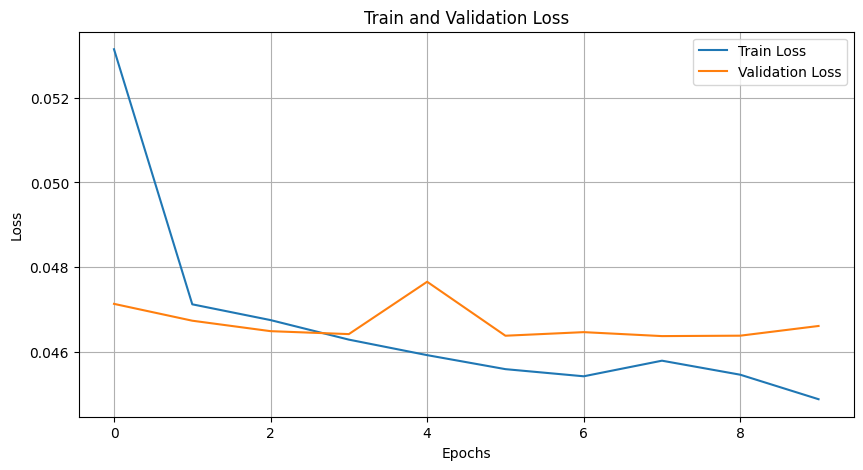

In [65]:
import matplotlib.pyplot as plt

# 손실 그래프 시각화
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.grid()
plt.show()


In [66]:
# 손실 그래프 시각화
plot_loss(history)

NameError: name 'plot_loss' is not defined